In [32]:
import os
import sys
sys.path.append("../../../")

from rnns_architectures.intrinsec import *
from rnns_architectures import utils
from IT_SHAP import TFWrapper, XAI_utils, utils_visualizations_IT_SHAP
from IT_SHAP.IT_SHAP import local_report
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import random, os, json
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
time = 14
norm = "robustNorm"

# EXPLAINABILITY. IT-SHAP

In [3]:
features =  ['AMG', 'CAR', 'CF1', 'CF3', 'CF4',
            'Others', 'GLI', 'LIN', 'LIP', 'MAC', 'NTI', 'OXA', 'PAP', 'PEN', 'POL',
            'QUI', 'SUL', 'hoursVM', 'acinet.$_{pc}$', 'enterobac.$_{pc}$', 'enteroc.$_{pc}$',
            'pseud.$_{pc}$', 'staph.$_{pc}$', 'others.$_{pc}$', 'hoursICU',
            '# pat_atb', '# pat_MR',
            'CAR.$_{n}$', 'PAP.$_{n}$', 'Falta.$_{n}$', 'QUI.$_{n}$',
            'OXA.$_{n}$', 'PEN.$_{n}$', 'CF3.$_{n}$', 'GLI.$_{n}$',
            'CF4.$_{n}$', 'SUL.$_{n}$', 'NTI.$_{n}$', 'LIN.$_{n}$',
            'AMG.$_{n}$', 'MAC.$_{n}$', 'CF1.$_{n}$', 'POL.$_{n}$',
            'LIP.$_{n}$', '# pat_ttl','posture.$_{change}$',
            'insulin', 'nutr_art', 'sedation', 'relax', 'hep_fail',
            'renal_fail', 'coag_fail', 'hemo_fail',
            'resp_fail', 'multi_fail', 'n_transf',
            'vasoactive.$_{drug}$', 'dosis_nems', 'hoursTracheo', 'hoursUlcer',
            'hoursHemo', 'C01 PIVC 1',
            'C01 PIVC 2', 'C02 CVC - YD',
            'C02 CVC - SD', 'C02 CVC - SI', 'C02 CVC - FD',
            'C02 CVC - YI', 'C02 CVC - FI', '# catheters']

print("# of features: ", len(features))

# Show the features in the plot with a clinical order
new_order = ['AMG', 'CAR', 'CF1', 'CF3', 'CF4',
            'Others', 'GLI', 'LIN', 'LIP', 'MAC', 'NTI', 'OXA', 'PAP', 'PEN', 'POL',
            'QUI', 'SUL','# pat_atb', '# pat_MR', '# pat_ttl', 'CAR.$_{n}$', 'PAP.$_{n}$', 'Falta.$_{n}$', 'QUI.$_{n}$',
            'OXA.$_{n}$', 'PEN.$_{n}$', 'CF3.$_{n}$', 'GLI.$_{n}$',
            'CF4.$_{n}$', 'SUL.$_{n}$', 'NTI.$_{n}$', 'LIN.$_{n}$',
            'AMG.$_{n}$', 'MAC.$_{n}$', 'CF1.$_{n}$', 'POL.$_{n}$',
            'LIP.$_{n}$', 'acinet.$_{pc}$', 'enterobac.$_{pc}$', 'enteroc.$_{pc}$',
            'pseud.$_{pc}$', 'staph.$_{pc}$', 'others.$_{pc}$',
            'posture.$_{change}$',
            'insulin', 'nutr_art', 'sedation', 'relax', 'hoursVM', 'resp_fail','hep_fail',
            'renal_fail', 'coag_fail', 'hemo_fail',
            'multi_fail', 'n_transf',
            'vasoactive.$_{drug}$', 'dosis_nems', 'hoursTracheo', 'hoursUlcer',
            'hoursHemo', 'hoursICU', 'C01 PIVC 1',
            'C01 PIVC 2', 'C02 CVC - YD',
            'C02 CVC - SD', 'C02 CVC - SI', 'C02 CVC - FD',
            'C02 CVC - YI', 'C02 CVC - FI', '# catheters' ]

feature_idx = {feature: idx for idx, feature in enumerate(features)}
reordered_indices = [feature_idx[feature] for feature in new_order]

# of features:  71


### Final name of the variables in the visualization 

In [4]:
final_order = ['AMG', 'CAR', 'CF1', 'CF3', 'CF4',
        'Others', 'GLI', 'LIN', 'LIP', 'MAC', 'NTI', 'OXA', 'PAP', 'PEN', 'POL',
        'QUI', 'SUL','# pat$_{atb}$', '# pat$_{MDR}$', '# pat$_{tot}$', 'CAR$_{n}$', 'PAP$_{n}$', 
        'Others$_{n}$', 'QUI$_{n}$',
        'OXA$_{n}$', 'PEN$_{n}$', 'CF3$_{n}$', 'GLI$_{n}$',
        'CF4$_{n}$', 'SUL$_{n}$', 'NTI$_{n}$', 'LIN$_{n}$',
        'AMG$_{n}$', 'MAC$_{n}$', 'CF1$_{n}$', 'POL$_{n}$',
        'LIP$_{n}$','Acinet$_{pc}$', 'Enterobac$_{pc}$', 'Enteroc$_{pc}$',
        'Pseud$_{pc}$', 'Staph$_{pc}$', 'Others$_{pc}$',
        'Post change',
        'Insulin', 'Art nutrition', 'Sedation', 'Relax', 'MV hours', 'Respiratory$_{fail}$','Hepatic$_{fail}$',
        'Renal$_{fail}$', 'Coagulation$_{fail}$', 'Hemodynamic$_{fail}$',
        'Multiorganic$_{fail}$', '# transfusions',
        'Vasoactive drug', 'Dosis nems', 'Tracheo hours', 'Ulcer hours',
        'Hemo hours', 'ICU hours', 'C01 PICC 1',
        'C01 PICC 2', 'C02 CVC - RJ',
        'C02 CVC - RS', 'C02 CVC - LS', 'C02 CVC - RF',
        'C02 CVC - LJ', 'C02 CVC - LF', '# catheters' ]

## Load each split and model and save the IT-SHAP values

# SPLIT 1

In [5]:
directory = './Results_Vanilla'
split = "s1"
norm = "robustNorm"

### POPULATION

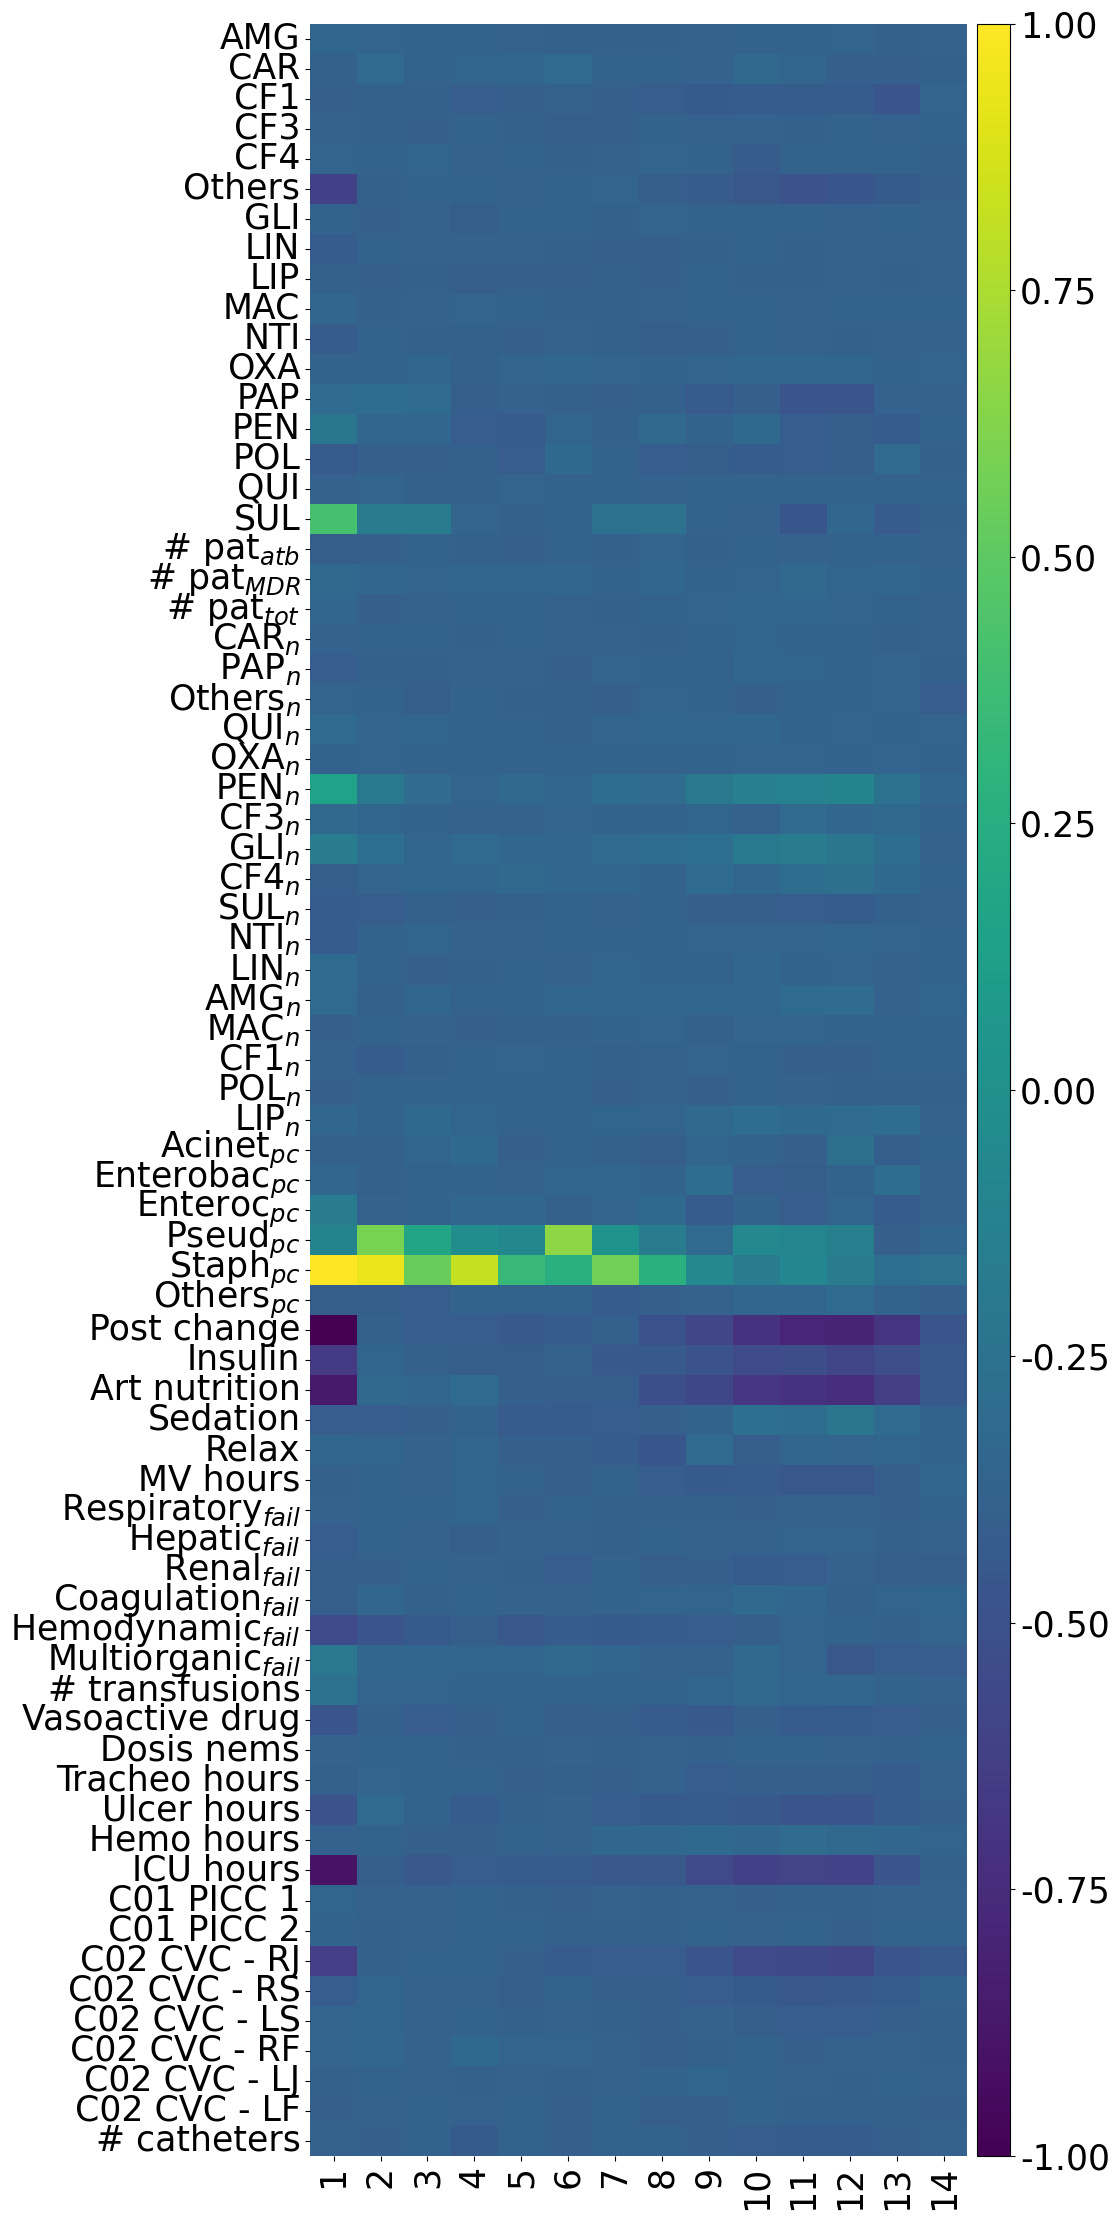

In [6]:
split_shap = utils_visualizations_IT_SHAP.load_from_pickle(os.path.join(directory, f"results_shap_{split}.pkl"))
matrix_pop = utils_visualizations_IT_SHAP.plot_shap_normalized(split_shap, features, reordered_indices, final_order,
                                                    f"../Figures/POST-HOC/SHAP_{split}_population_vanilla.pdf", time, save_img=True)

### MDR PATIENTS

In [7]:
ign_pat = []
X_test = np.load(f"../../../DATA/MDR/{split}/X_test_tensor_{norm}.npy")
for idx_pat in range(X_test.shape[0]):
    X = X_test[idx_pat]
    rows_filtered = np.any(X == 666, axis=-1)
    if len(rows_filtered[rows_filtered == False]) == 1:
        ign_pat.append(idx_pat)
        
y_test = pd.read_csv(f"../../../DATA/MDR/{split}/y_test_tensor_{norm}.csv")
y_test_f = y_test.loc[:, 'individualMRGerm'].values.reshape(y_test.shape[0] // time, time)
y_test_f = np.delete(y_test_f, ign_pat, axis=0)
y_test_f.shape

(1041, 14)

In [8]:
import copy
list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

split_shap_amr = []

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 0:
            patient_shap.loc[:, col] = np.nan #NonAMR patients are set to Nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #AMR patients keep the info

    split_shap_amr.append(patient_shap)


**Visualize the MDR data without normalization**

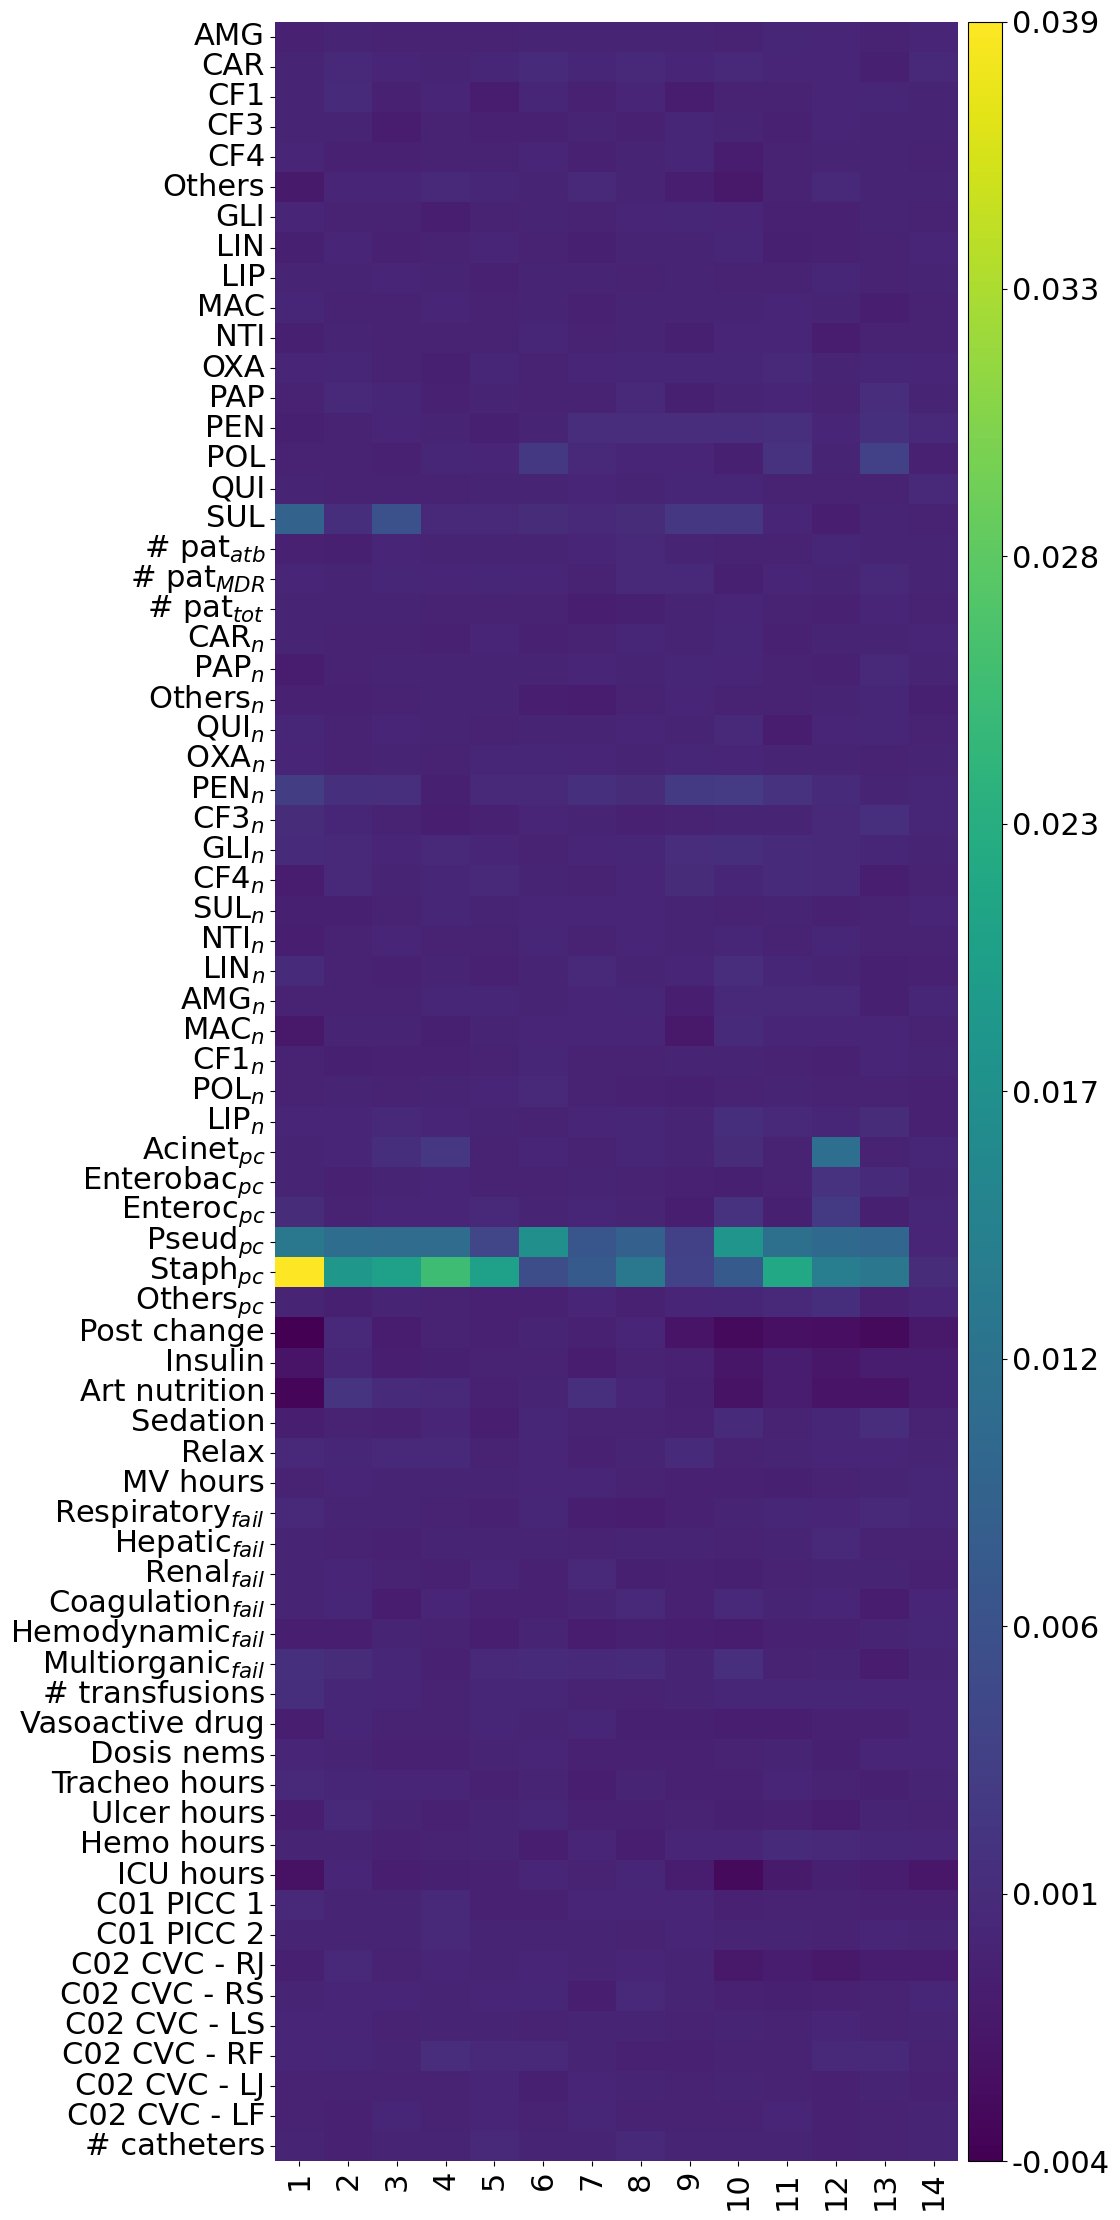

In [9]:
matrix_amr = utils_visualizations_IT_SHAP.plot_shap(split_shap_amr, features, reordered_indices, final_order,
                                                    f"", time,save_img=False)

**Visualize the MDR data with normalization**

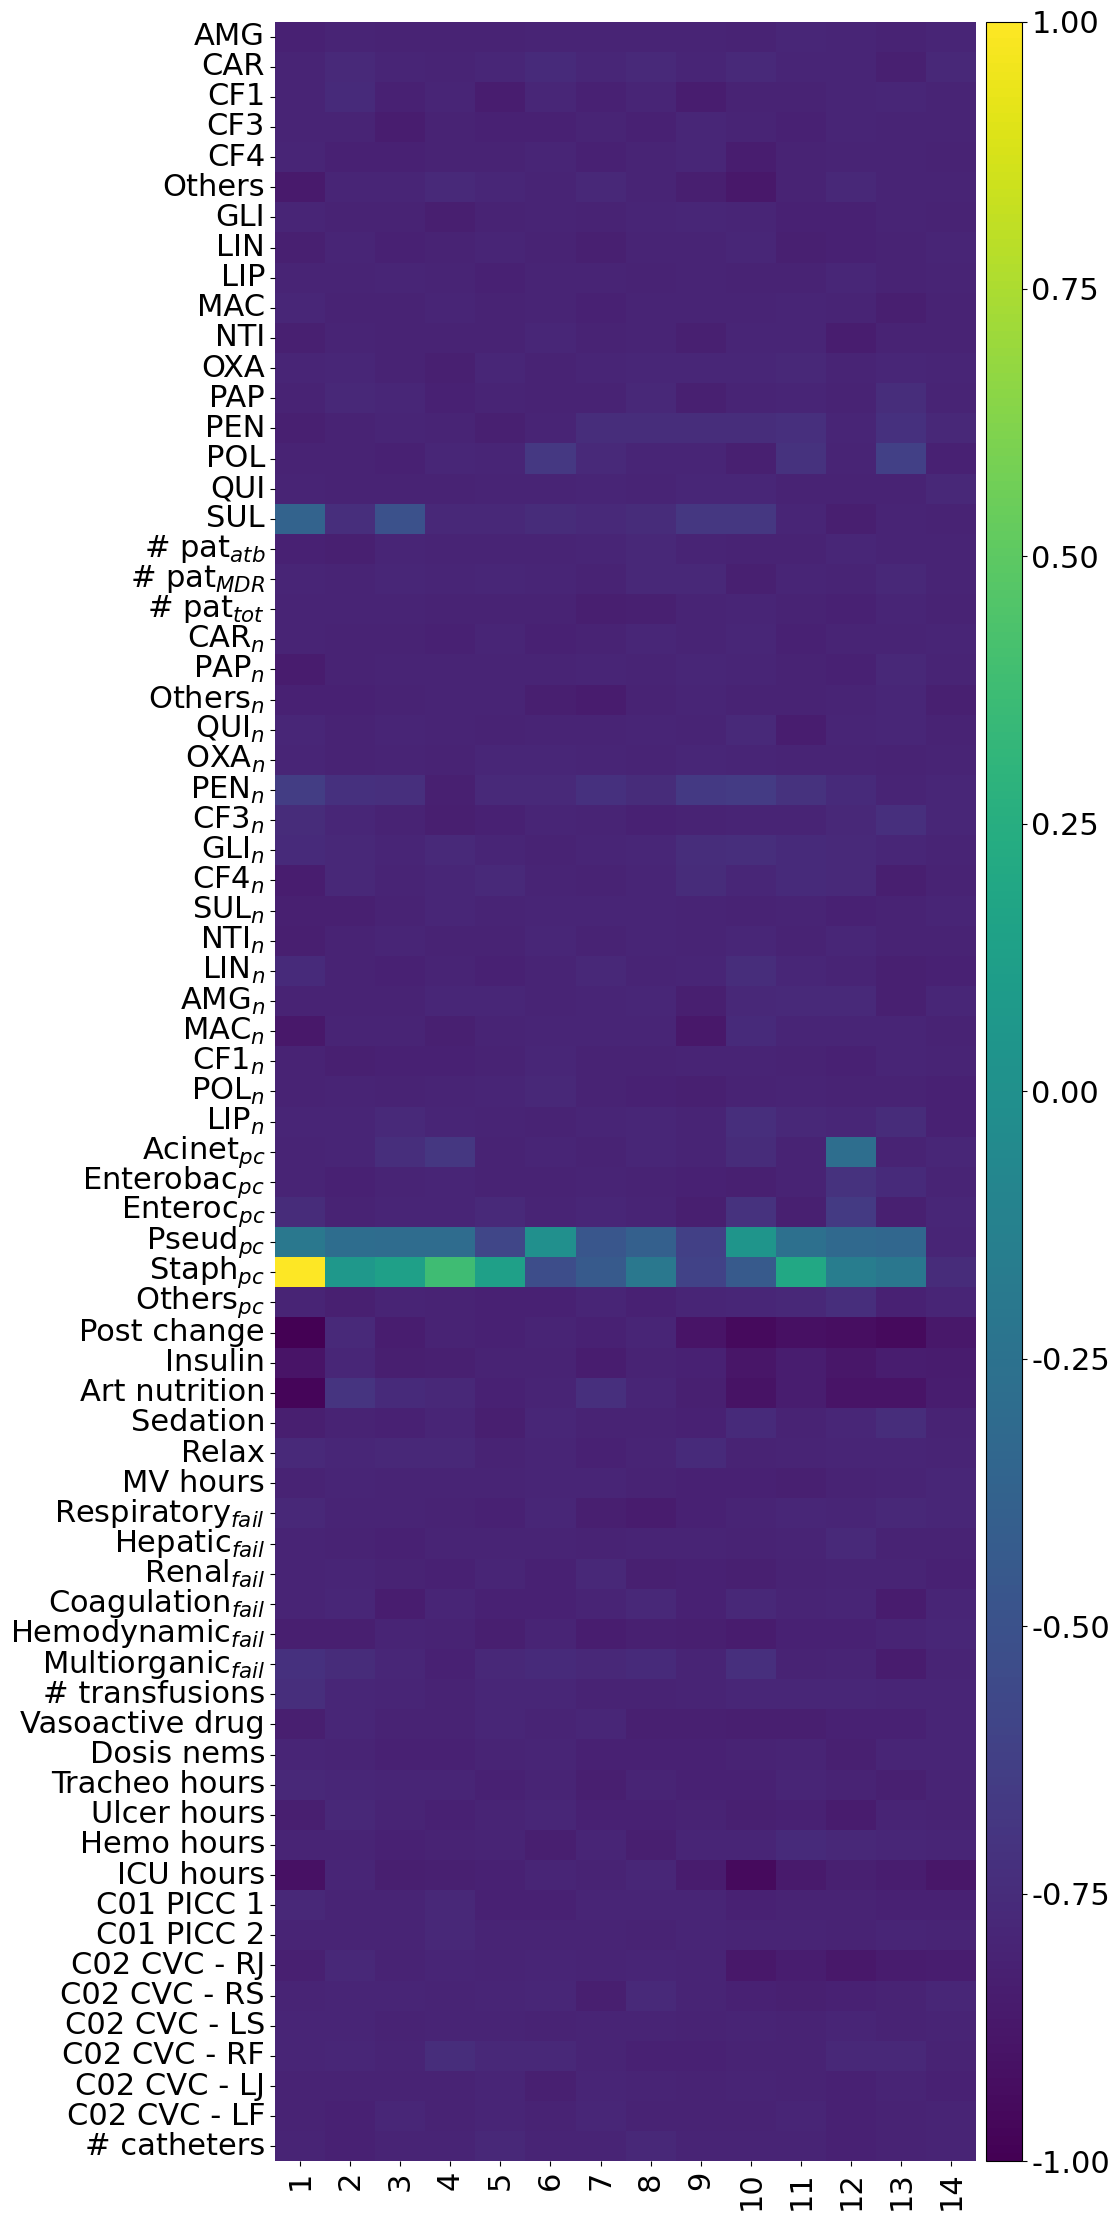

In [10]:
utils_visualizations_IT_SHAP.plot_shap_norm(matrix_pop, 
               matrix_amr, 
               reordered_indices,
               final_order,
               f"../Figures/POST-HOC/SHAP_{split}_mdr_vanilla.pdf", 
               time,
               save_img=True
) 

## NON MDR PATIENTS

In [11]:
split_shap_noamr = []

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 1: #AMR patients are set to Nan
            patient_shap.loc[:, col] = np.nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #NonAMR patients keep the info

    split_shap_noamr.append(patient_shap)

**Visualize the Non MDR data without normalization**

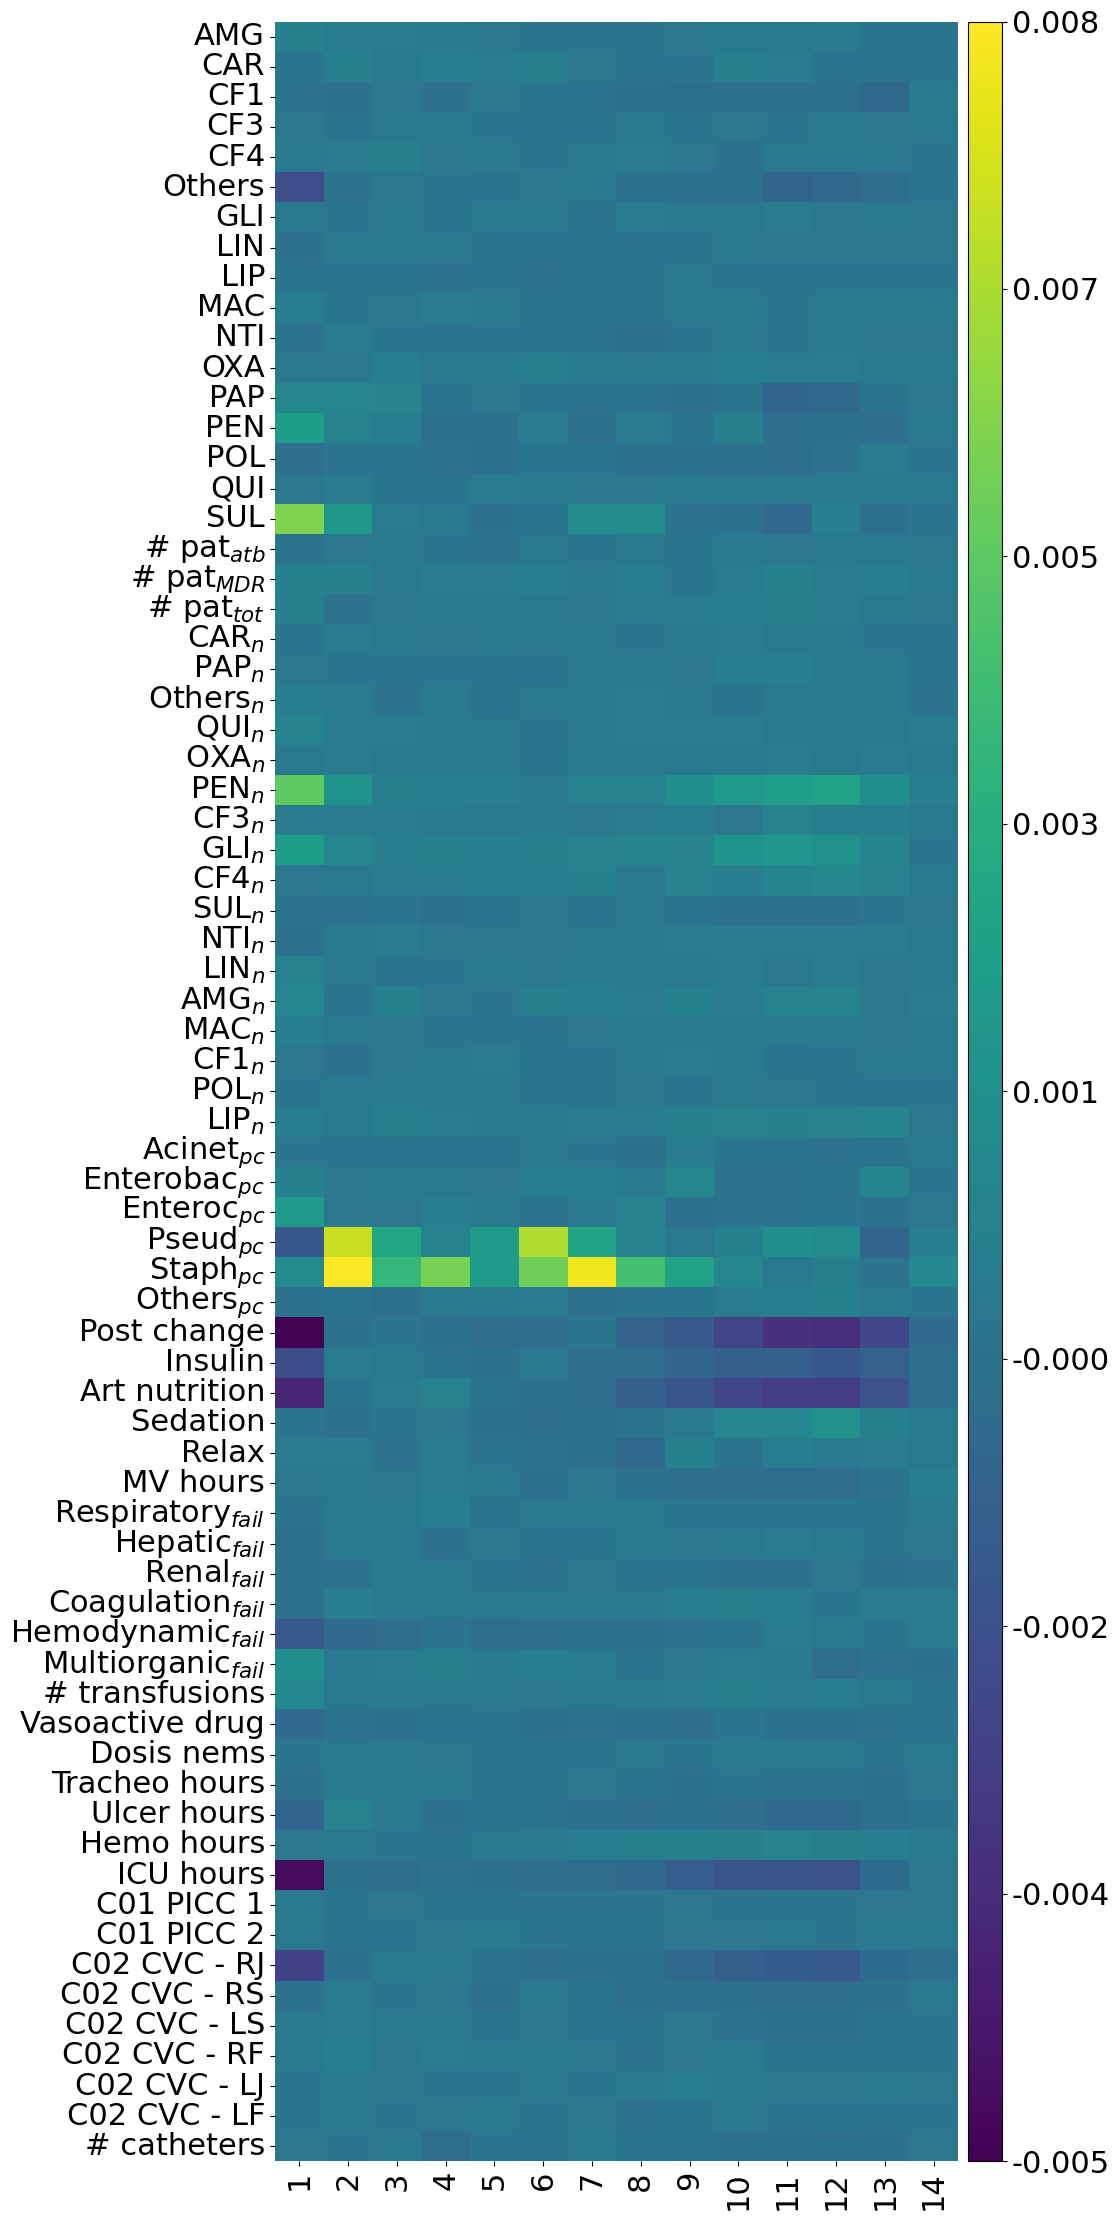

In [12]:
matrix_noamr = utils_visualizations_IT_SHAP.plot_shap(split_shap_noamr, features, reordered_indices, final_order,
                                                      f" ", time, save_img=False)

**Visualize the Non MDR data with normalization**

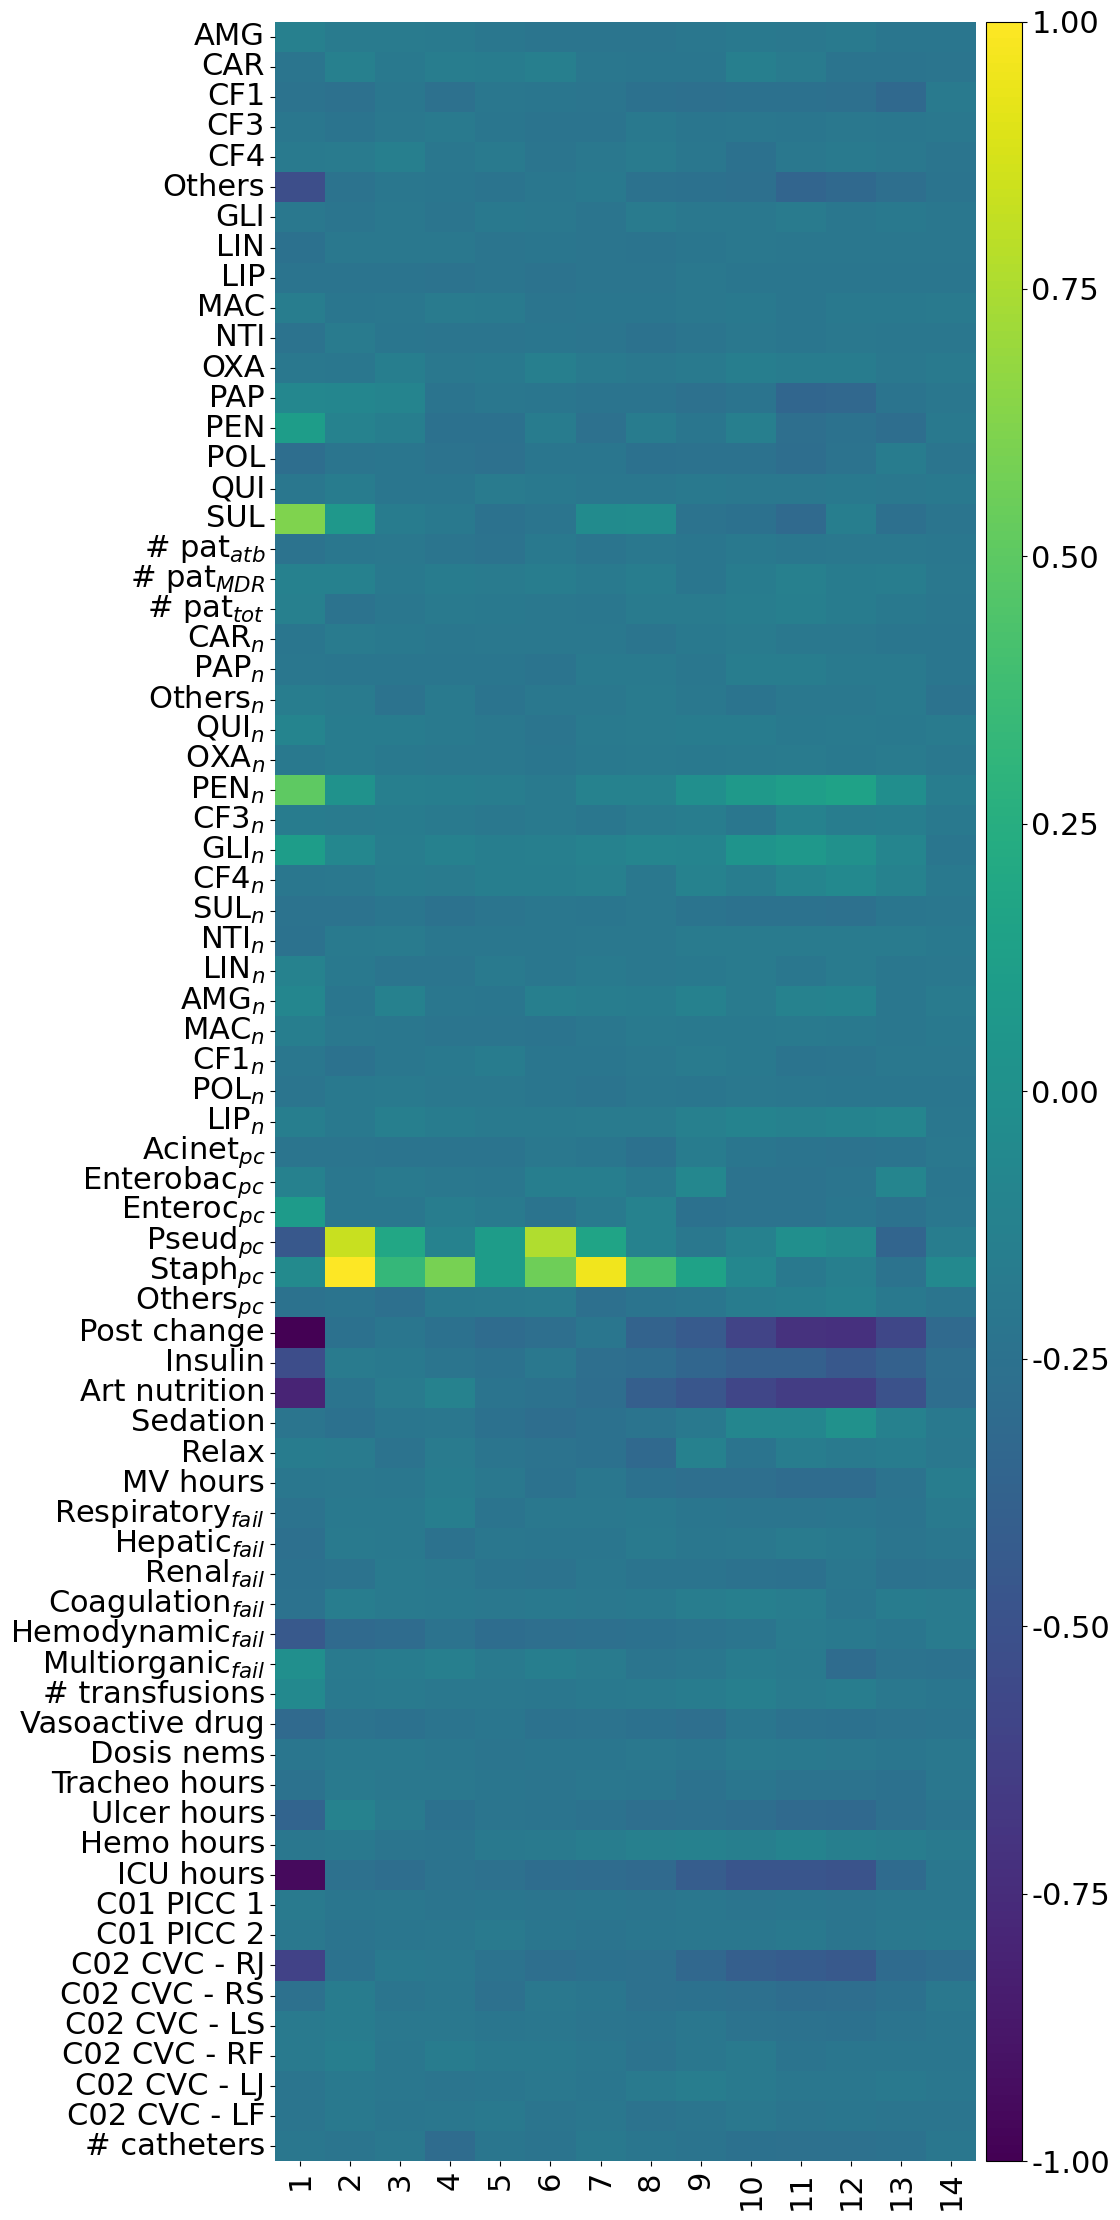

In [13]:
utils_visualizations_IT_SHAP.plot_shap_norm(matrix_pop, 
               matrix_noamr, 
               reordered_indices, 
               final_order,
               f"../Figures/POST-HOC/SHAP_{split}_nomdr_vanilla.pdf", 
               time,
               save_img=True
) 

# SPLIT 2

In [14]:
directory = './Results_Vanilla'
split = "s2"
norm = "robustNorm"

### POPULATION

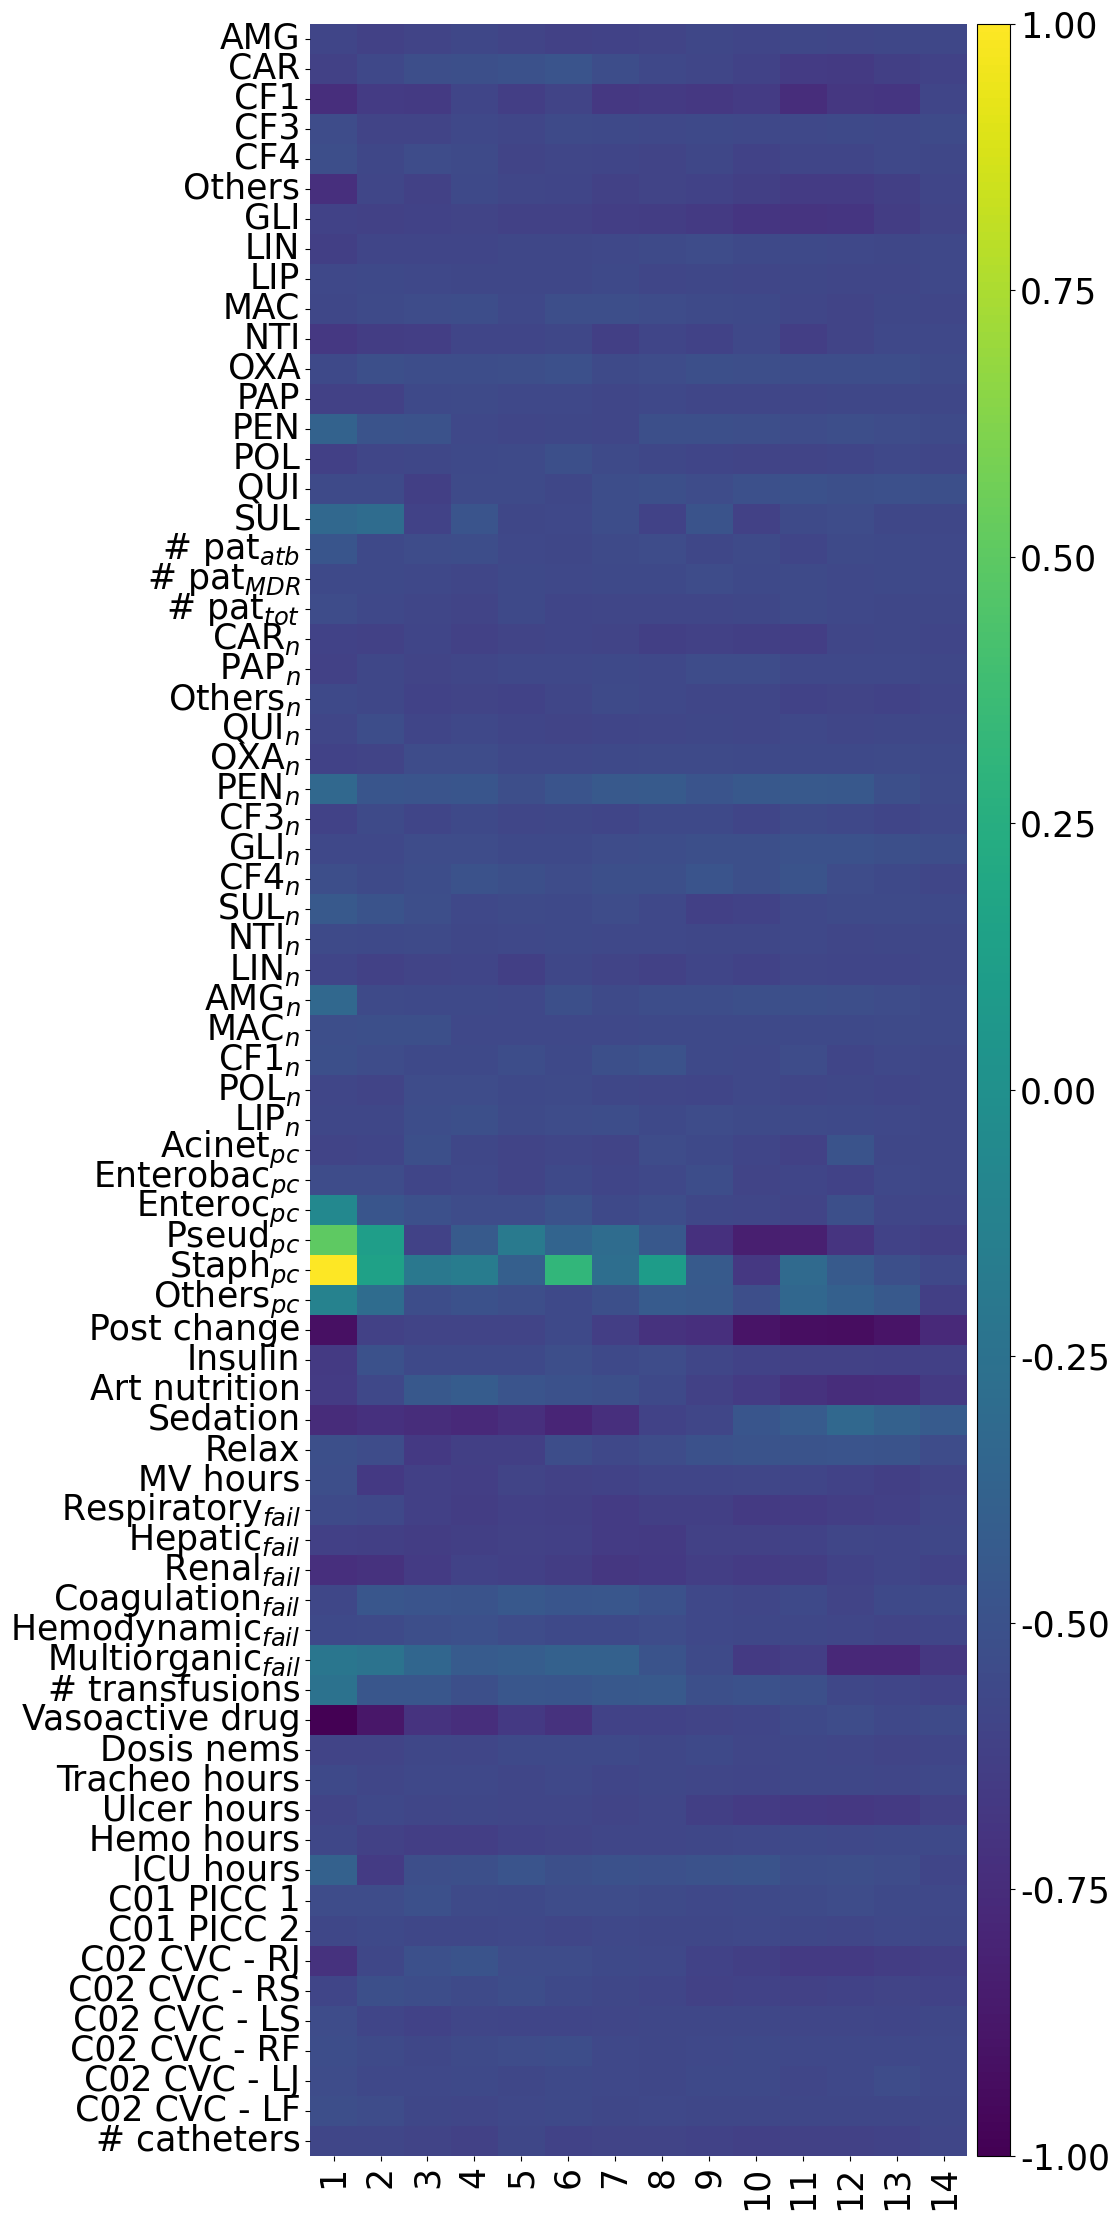

In [15]:
split_shap = utils_visualizations_IT_SHAP.load_from_pickle(os.path.join(directory, f"results_shap_{split}.pkl"))
matrix_pop = utils_visualizations_IT_SHAP.plot_shap_normalized(split_shap, features, reordered_indices, final_order,
                                                    f"../Figures/POST-HOC/SHAP_{split}_population_vanilla.pdf", time, save_img=True)

### MDR PATIENTS

In [16]:
ign_pat = []
X_test = np.load(f"../../../DATA/MDR/{split}/X_test_tensor_{norm}.npy")
for idx_pat in range(X_test.shape[0]):
    X = X_test[idx_pat]
    rows_filtered = np.any(X == 666, axis=-1)
    if len(rows_filtered[rows_filtered == False]) == 1:
        ign_pat.append(idx_pat)
        
y_test = pd.read_csv(f"../../../DATA/MDR/{split}/y_test_tensor_{norm}.csv")
y_test_f = y_test.loc[:, 'individualMRGerm'].values.reshape(y_test.shape[0] // time, time)
y_test_f = np.delete(y_test_f, ign_pat, axis=0)
y_test_f.shape

(1041, 14)

In [17]:
import copy

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

split_shap_amr = []

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 0:
            patient_shap.loc[:, col] = np.nan #NonAMR patients are set to Nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #AMR patients keep the info

    split_shap_amr.append(patient_shap)


**Visualize the MDR data without normalization**

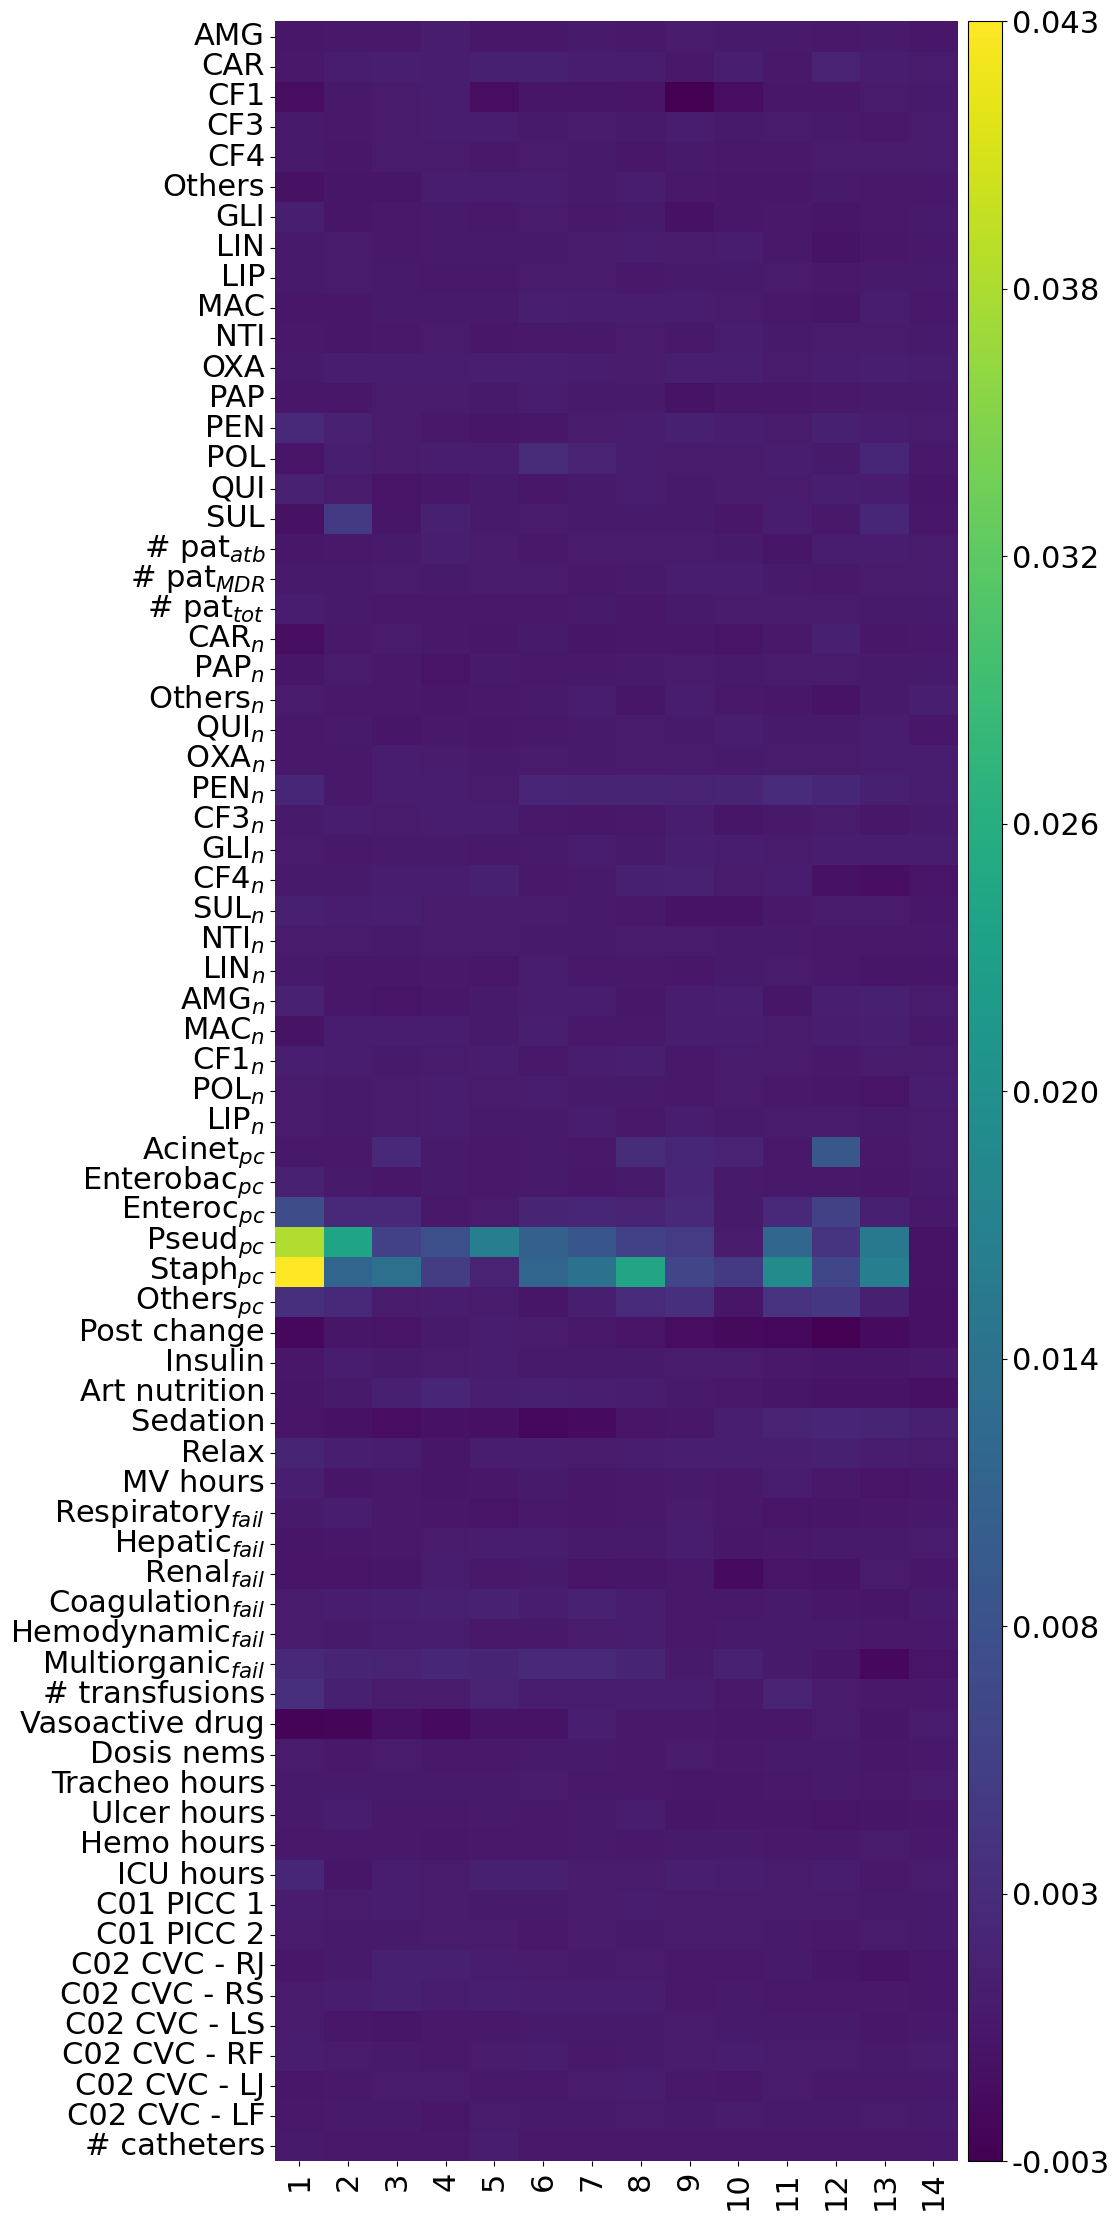

In [18]:
matrix_amr = utils_visualizations_IT_SHAP.plot_shap(split_shap_amr, features, reordered_indices, final_order,
                                                    f"", time, save_img=False)

**Visualize the MDR data with normalization**

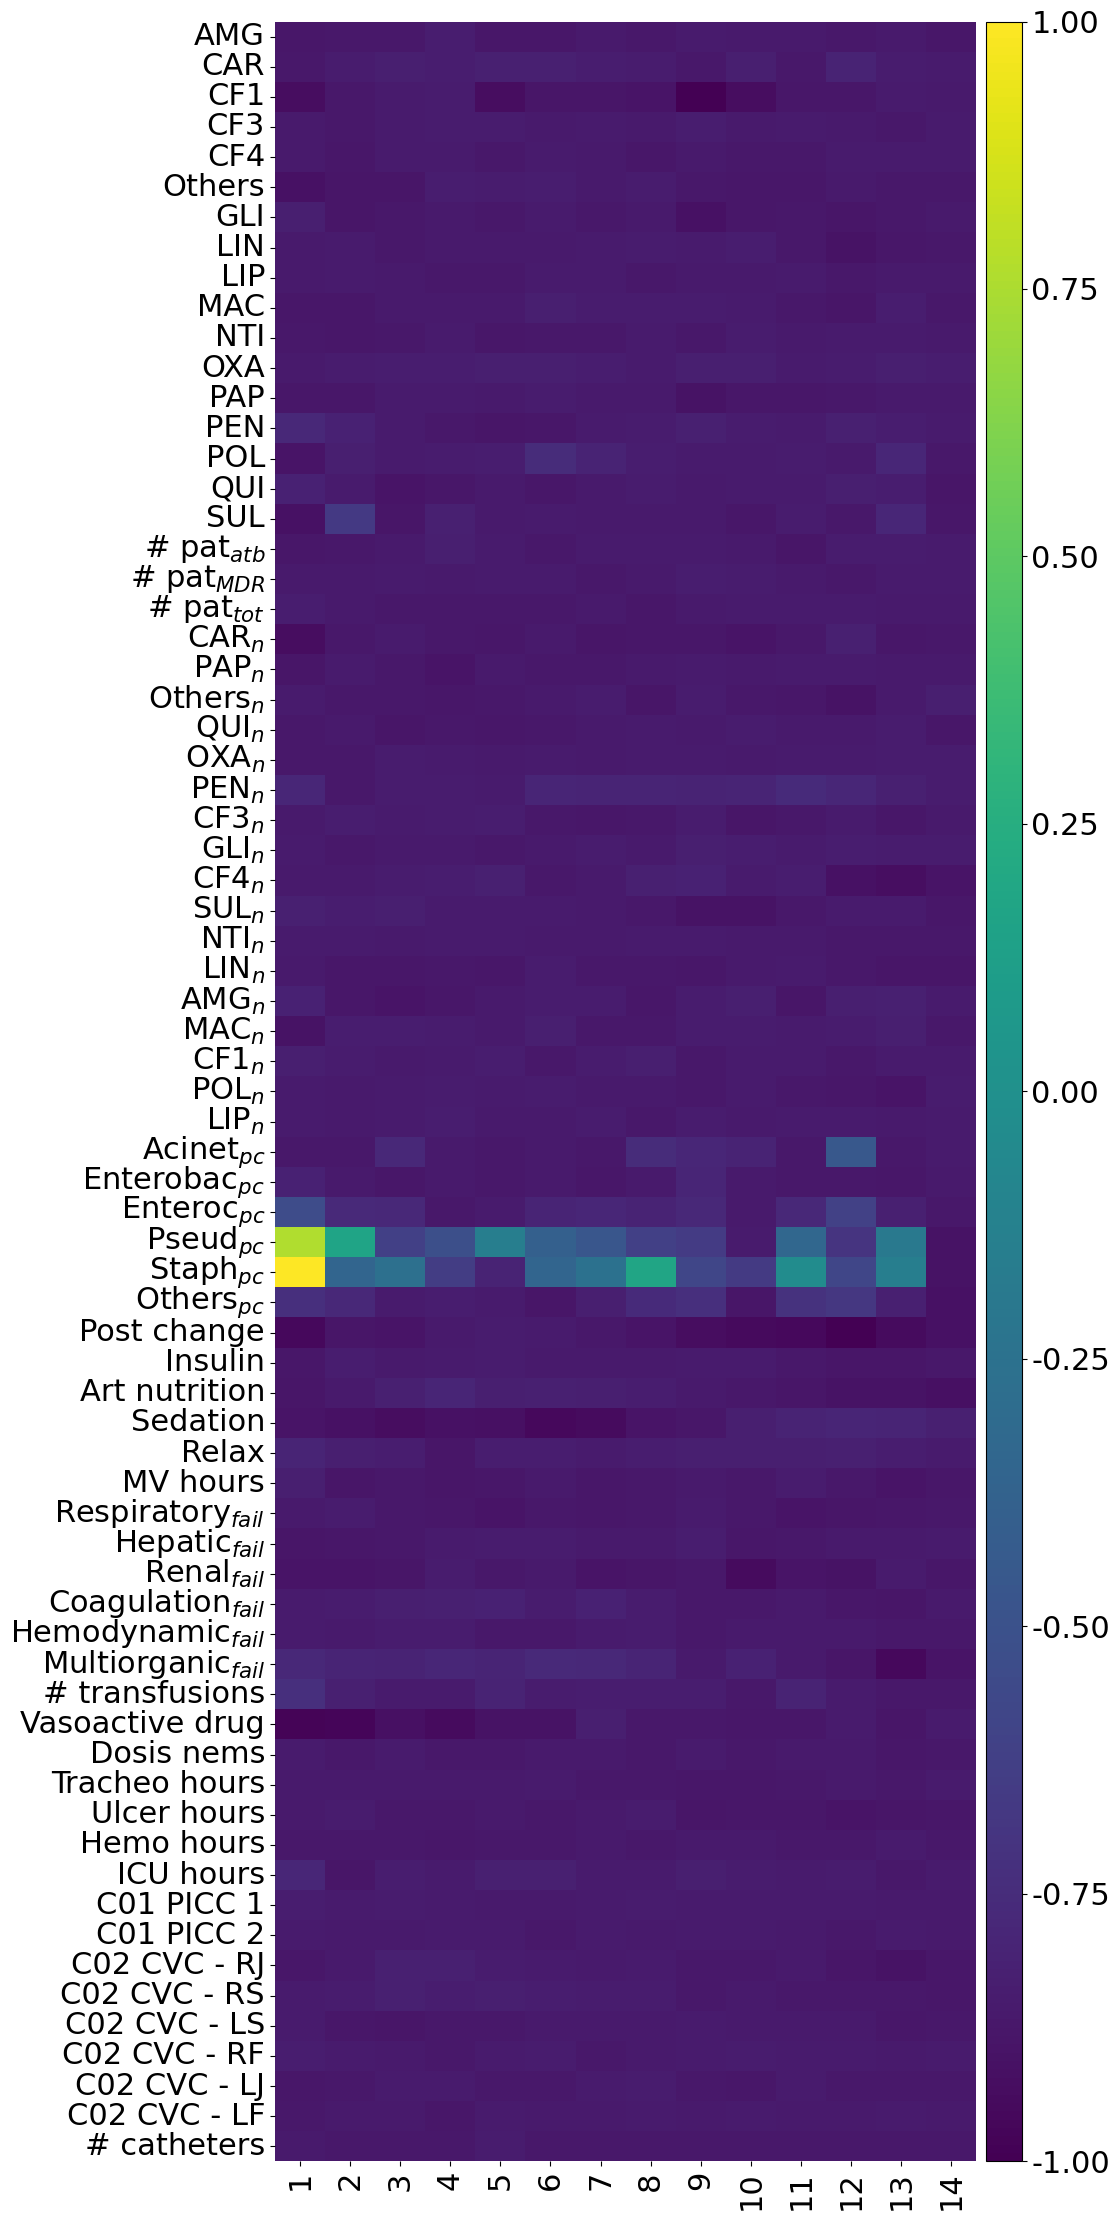

In [19]:
utils_visualizations_IT_SHAP.plot_shap_norm(matrix_pop, 
               matrix_amr, 
               reordered_indices,
               final_order,
               f"../Figures/POST-HOC/SHAP_{split}_mdr_vanilla.pdf", 
               time, 
               save_img=True
) 

## NON MDR PATIENTS

In [20]:
split_shap_noamr = []

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 1: #MDR patients are set to Nan
            patient_shap.loc[:, col] = np.nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #NonMDR patients keep the info

    split_shap_noamr.append(patient_shap)

**Visualize the Non MDR data without normalization**

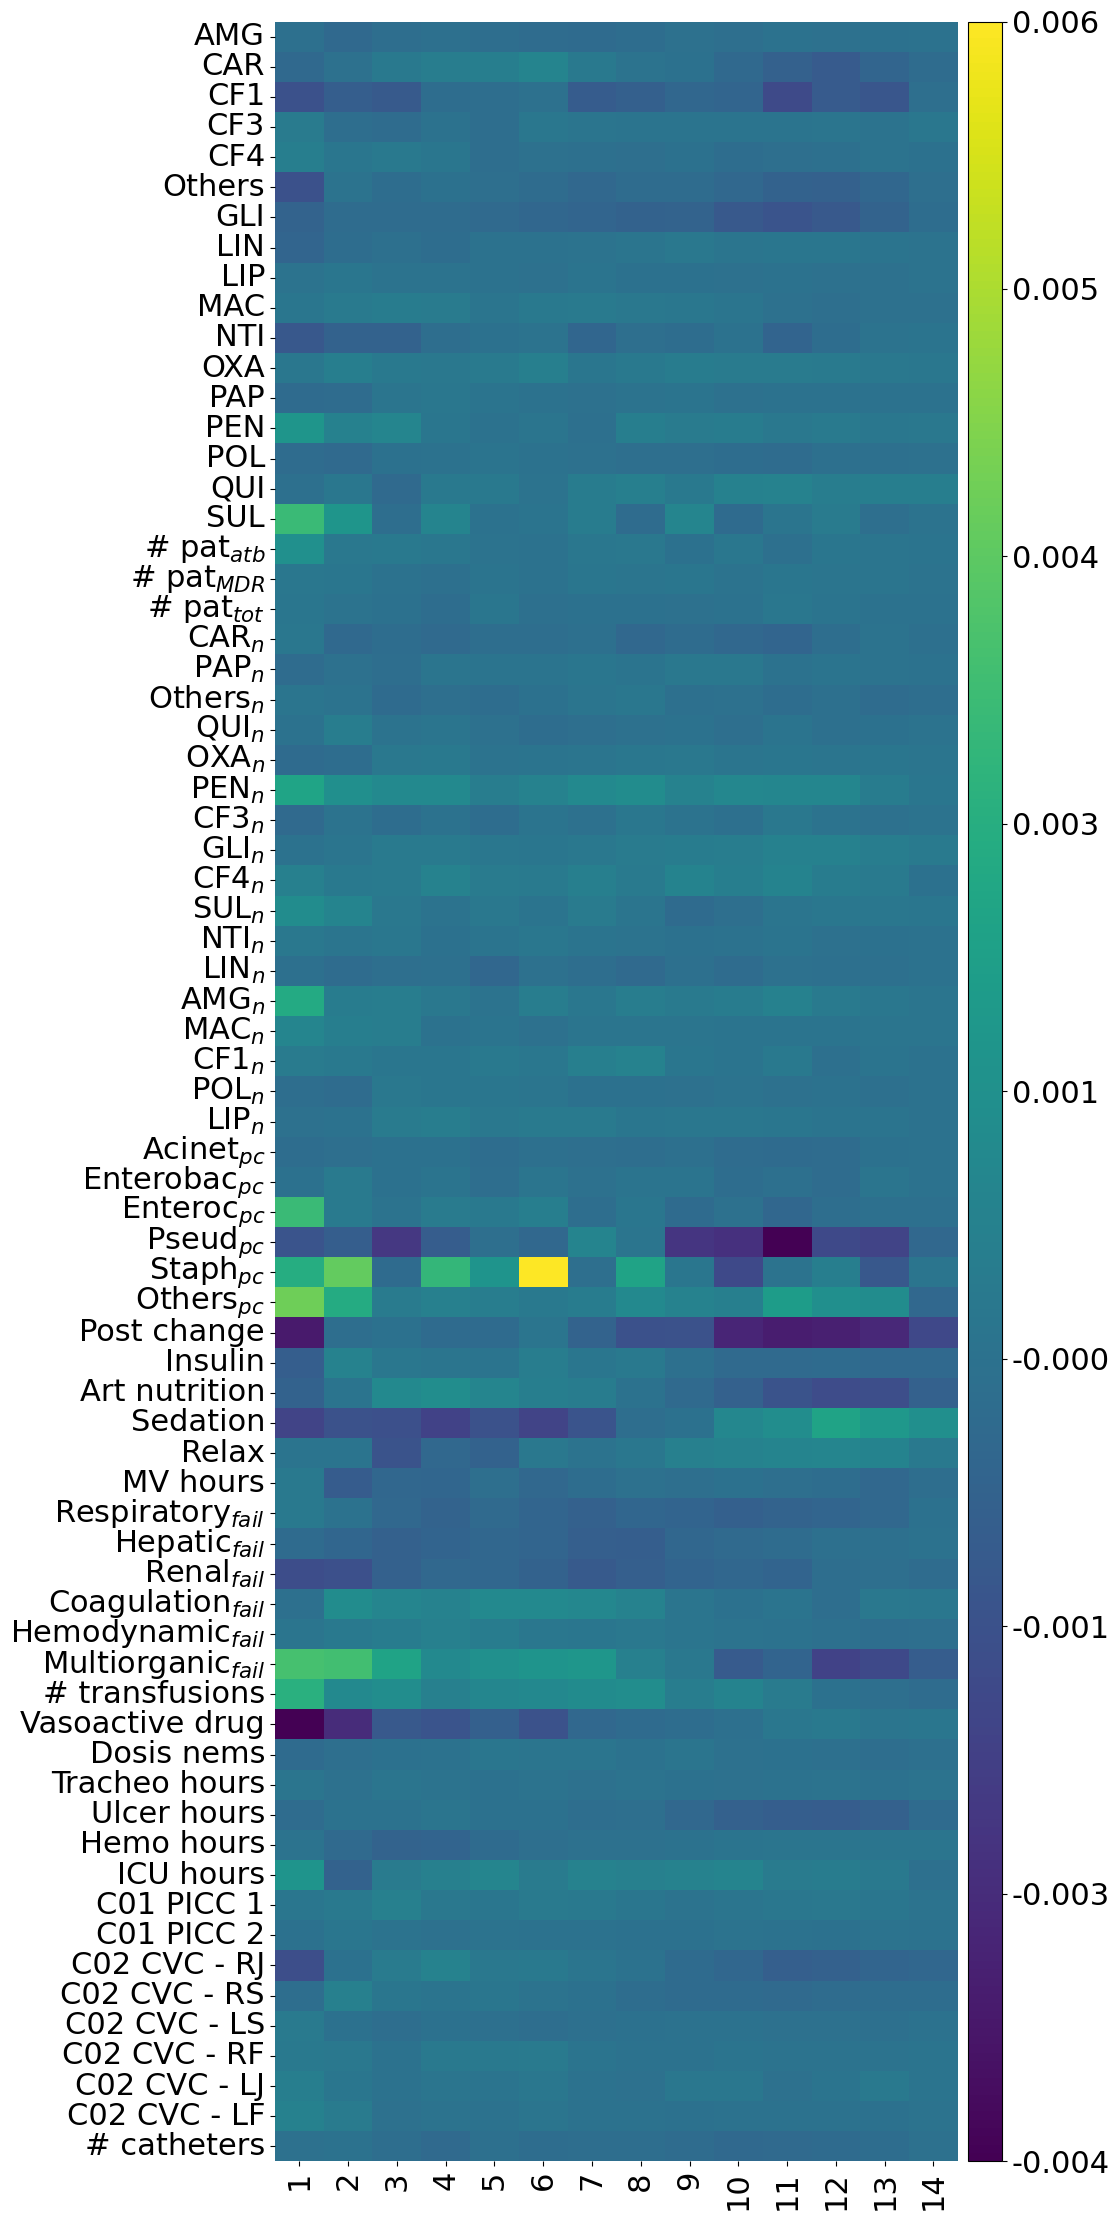

In [21]:
matrix_noamr = utils_visualizations_IT_SHAP.plot_shap(split_shap_noamr, features, reordered_indices, final_order,
                                                      f" ", time, save_img=False)

**Visualize the Non MDR data with normalization**

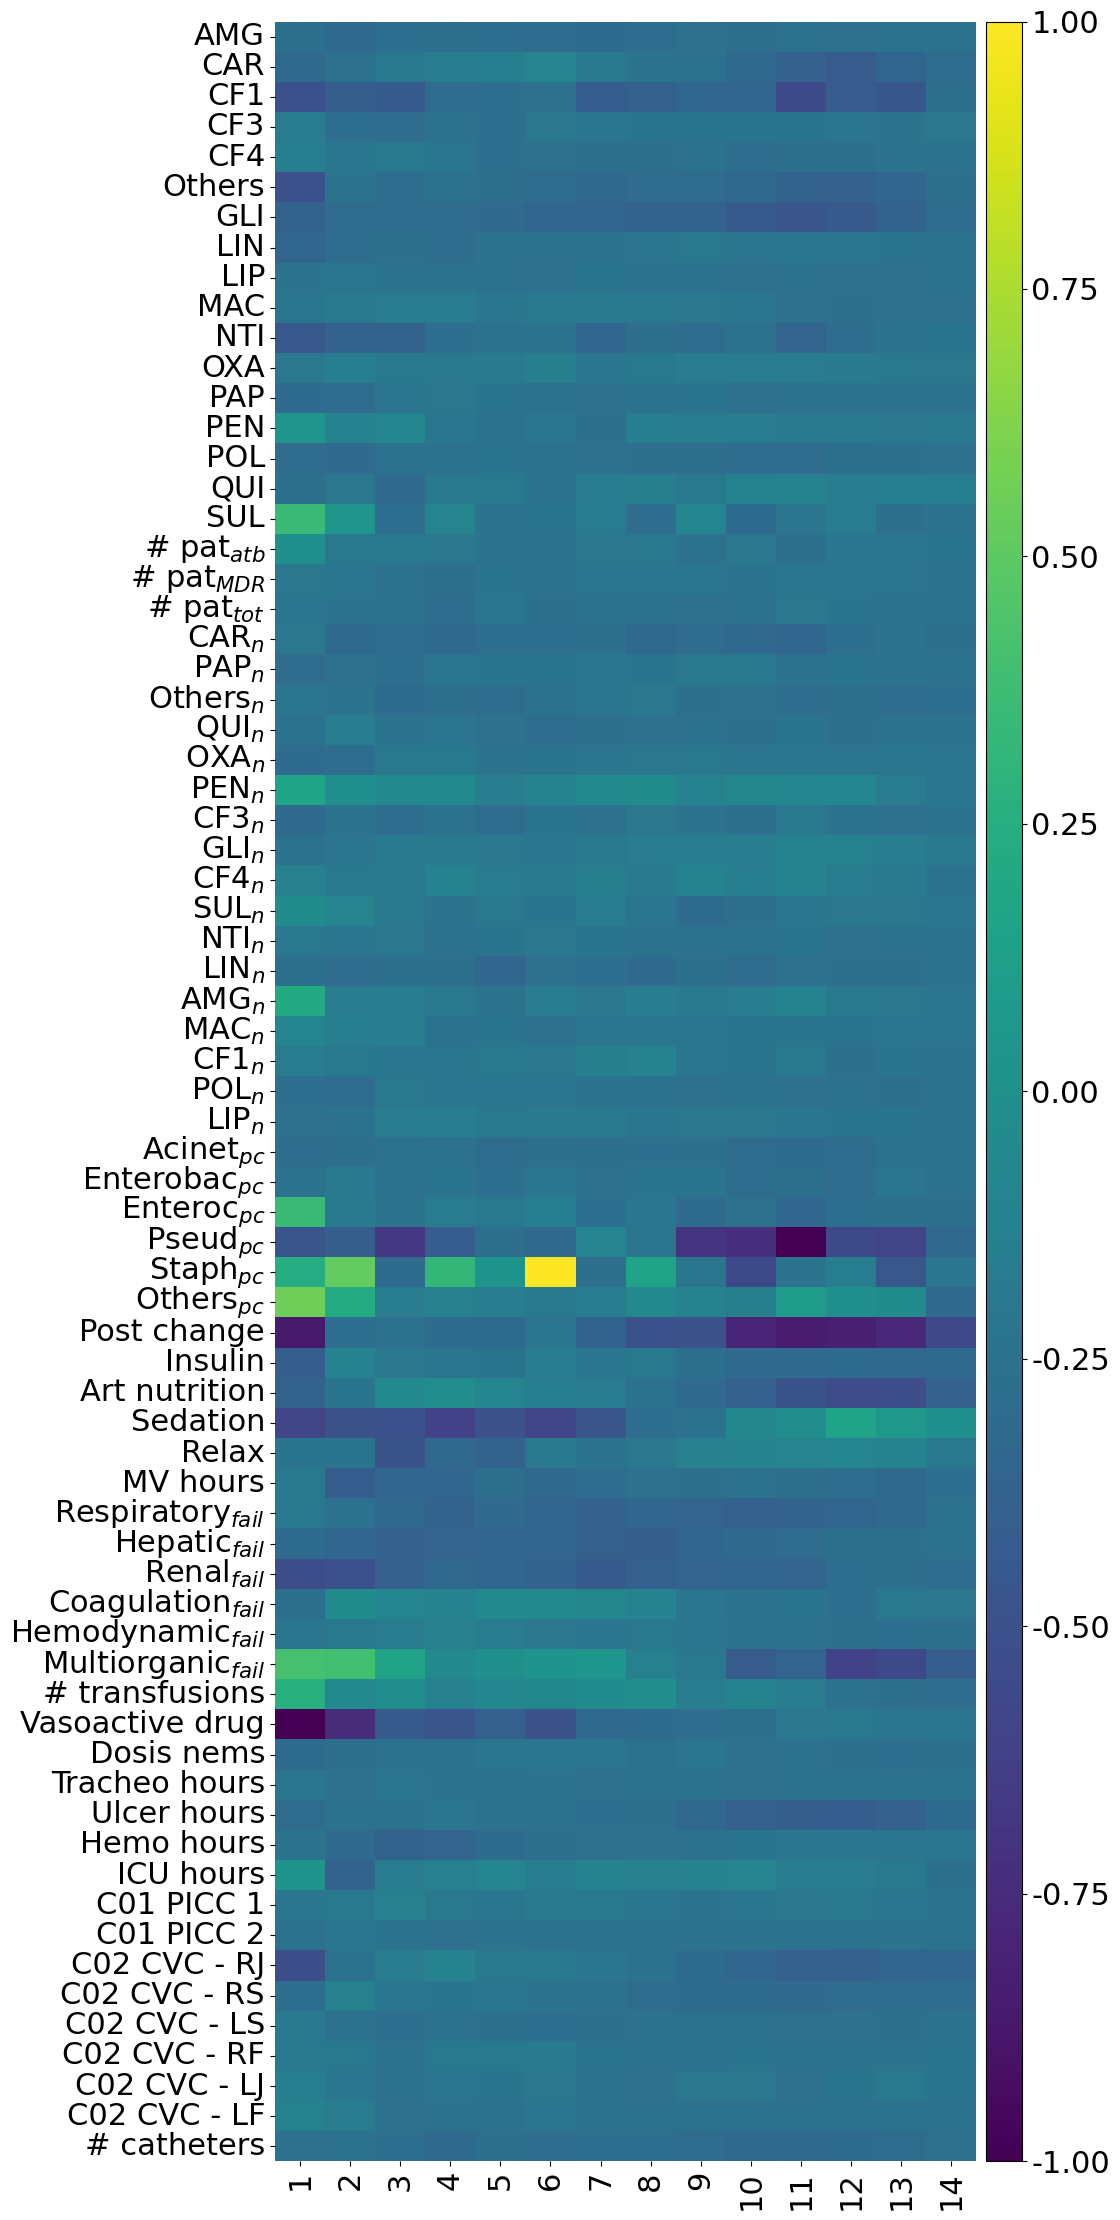

In [22]:
utils_visualizations_IT_SHAP.plot_shap_norm(matrix_pop, 
               matrix_noamr, 
               reordered_indices, 
               final_order,
               f"../Figures/POST-HOC/SHAP_{split}_nomdr_vanilla.pdf", 
               time,
               save_img=True
) 

# SPLIT 3

In [23]:
directory = './Results_Vanilla'
split = "s3"
norm = "robustNorm"

### POPULATION

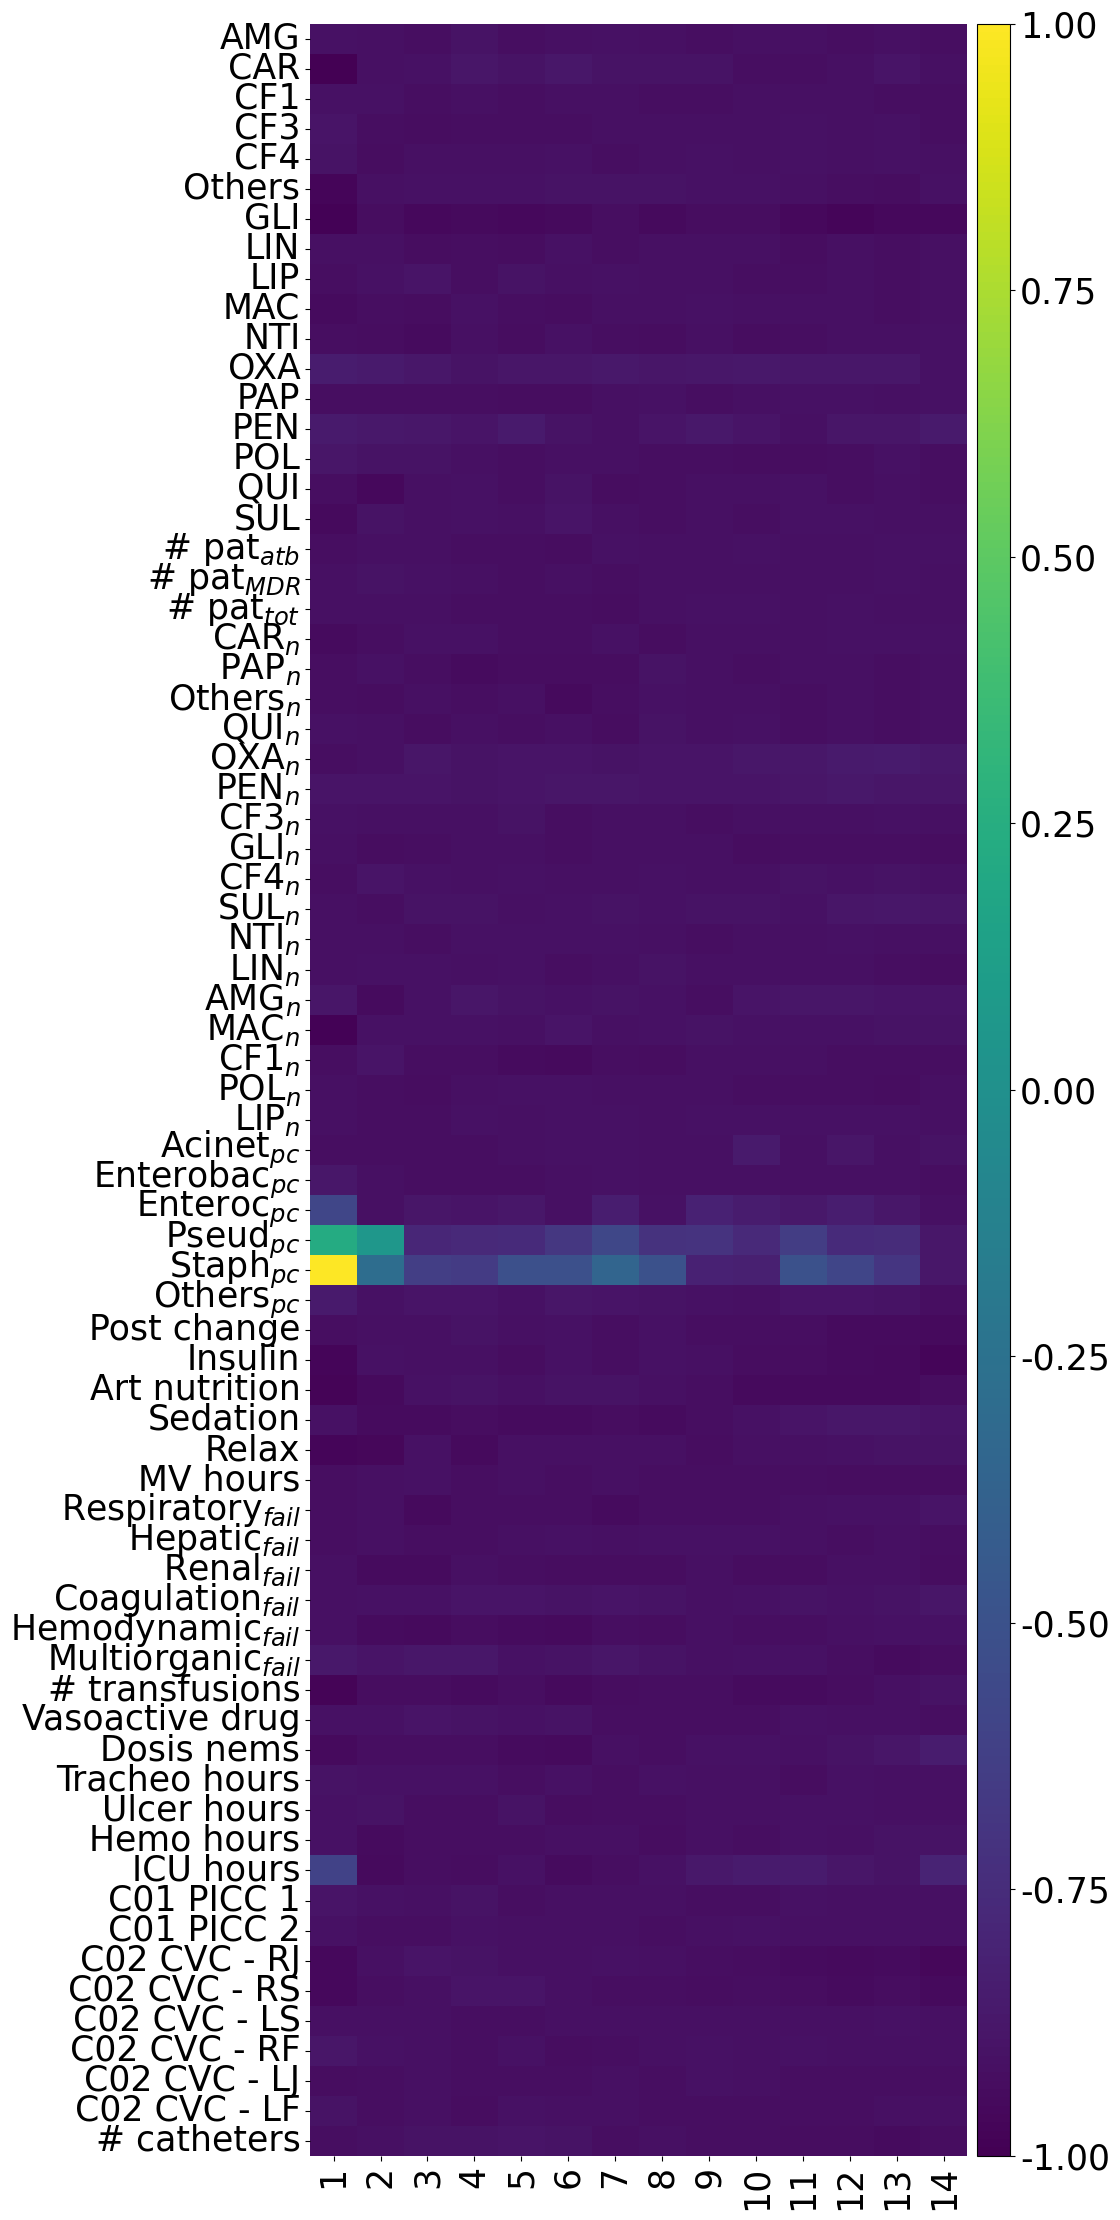

In [24]:
split_shap = utils_visualizations_IT_SHAP.load_from_pickle(os.path.join(directory, f"results_shap_{split}.pkl"))
matrix_pop = utils_visualizations_IT_SHAP.plot_shap_normalized(split_shap, features, reordered_indices, final_order,
                                                    f"../Figures/POST-HOC/SHAP_{split}_population_vanilla.pdf", time, save_img=True)

### MDR PATIENTS

In [25]:
ign_pat = []
X_test = np.load(f"../../../DATA/MDR/{split}/X_test_tensor_{norm}.npy")
for idx_pat in range(X_test.shape[0]):
    X = X_test[idx_pat]
    rows_filtered = np.any(X == 666, axis=-1)
    if len(rows_filtered[rows_filtered == False]) == 1:
        ign_pat.append(idx_pat)
        
y_test = pd.read_csv(f"../../../DATA/MDR/{split}/y_test_tensor_{norm}.csv")
y_test_f = y_test.loc[:, 'individualMRGerm'].values.reshape(y_test.shape[0] // time, time)
y_test_f = np.delete(y_test_f, ign_pat, axis=0)
y_test_f.shape

(1041, 14)

In [26]:
import copy

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

split_shap_amr = []

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 0:
            patient_shap.loc[:, col] = np.nan #NonAMR patients are set to Nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #AMR patients keep the info

    split_shap_amr.append(patient_shap)


**Visualize the MDR data without normalization**

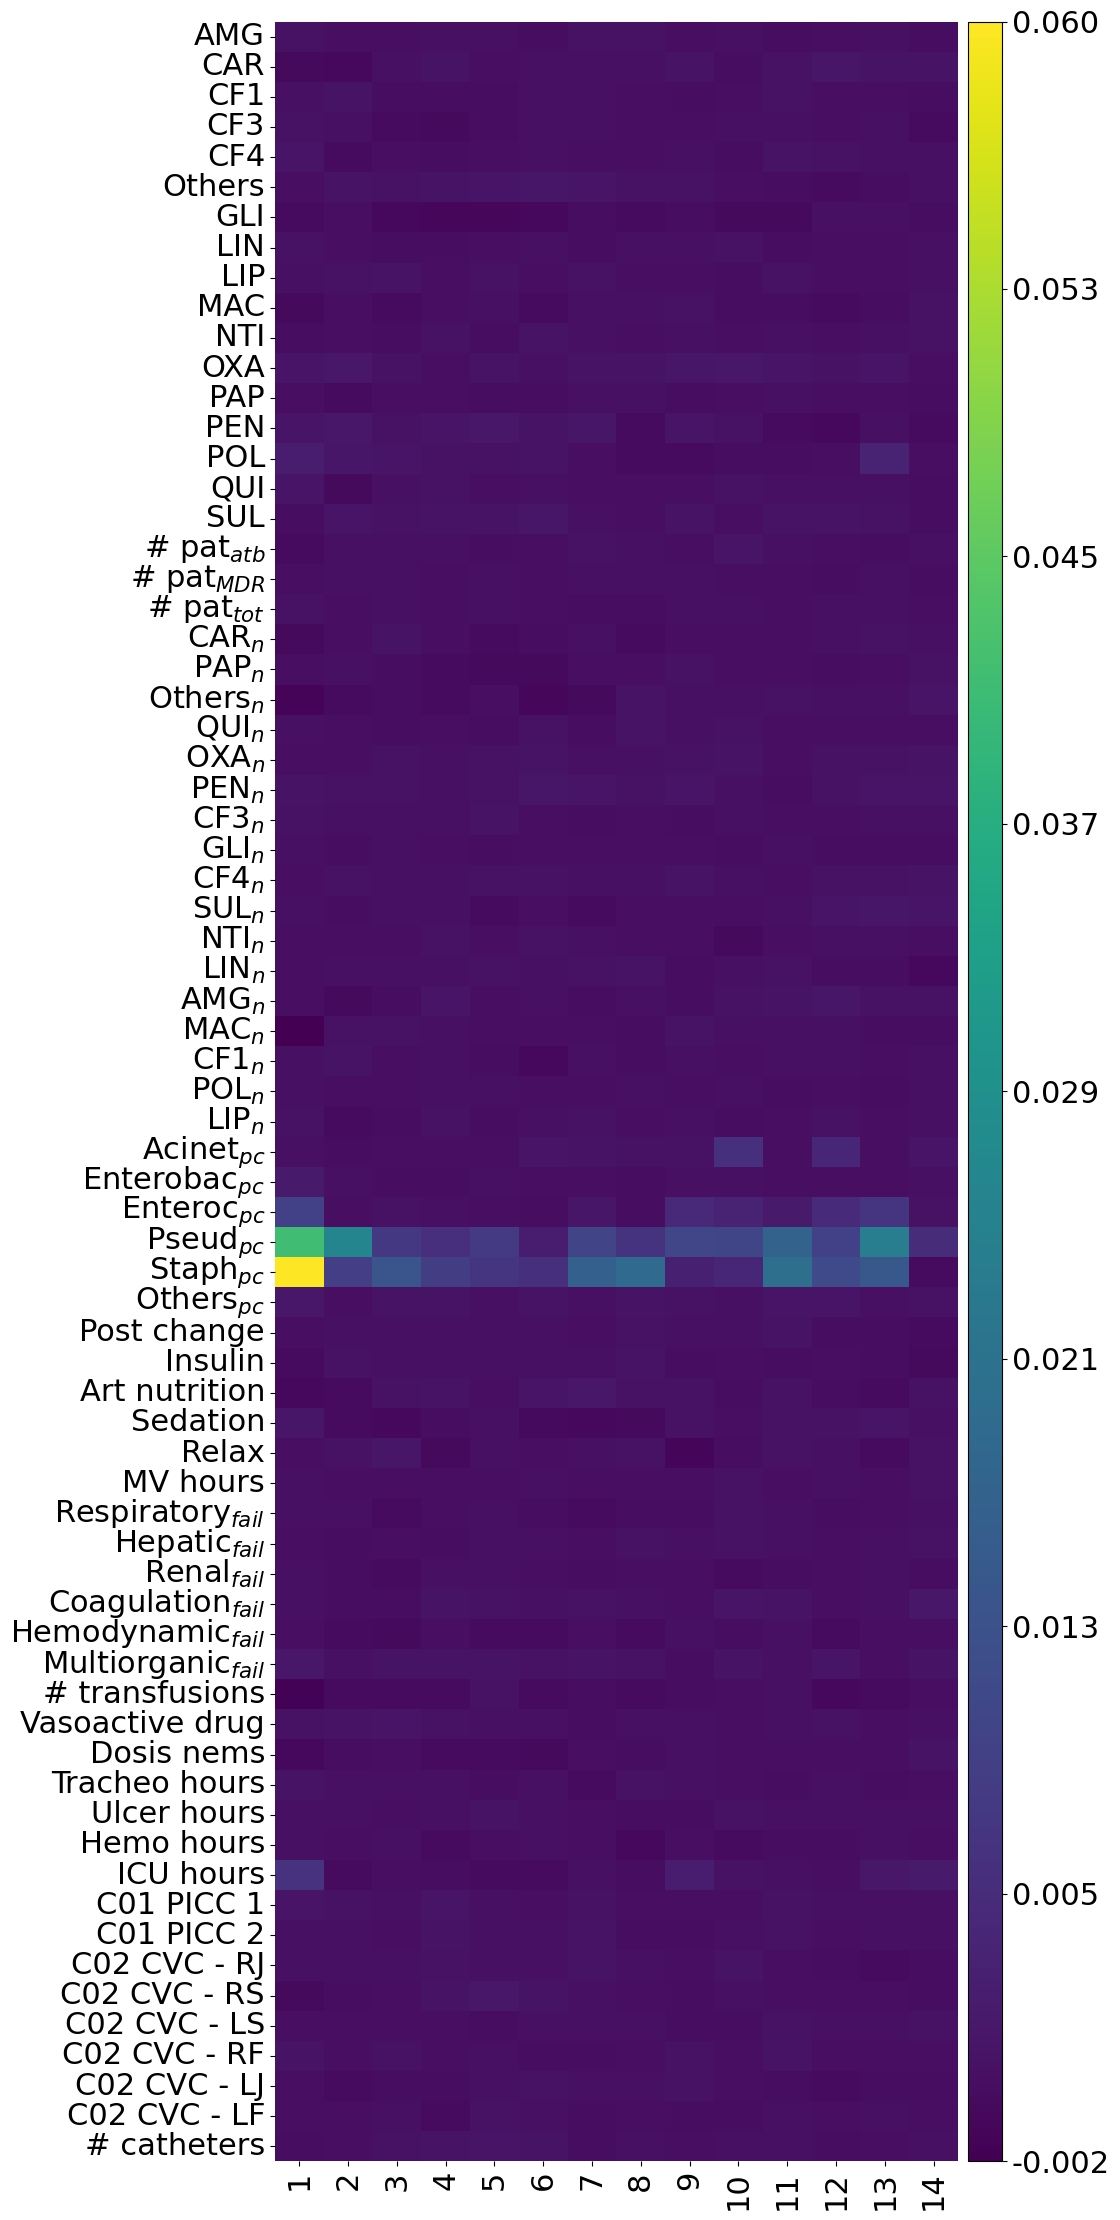

In [27]:
matrix_amr = utils_visualizations_IT_SHAP.plot_shap(split_shap_amr, features, reordered_indices, final_order,
                                                    f"", time, save_img=False)

**Visualize the MDR data with normalization**

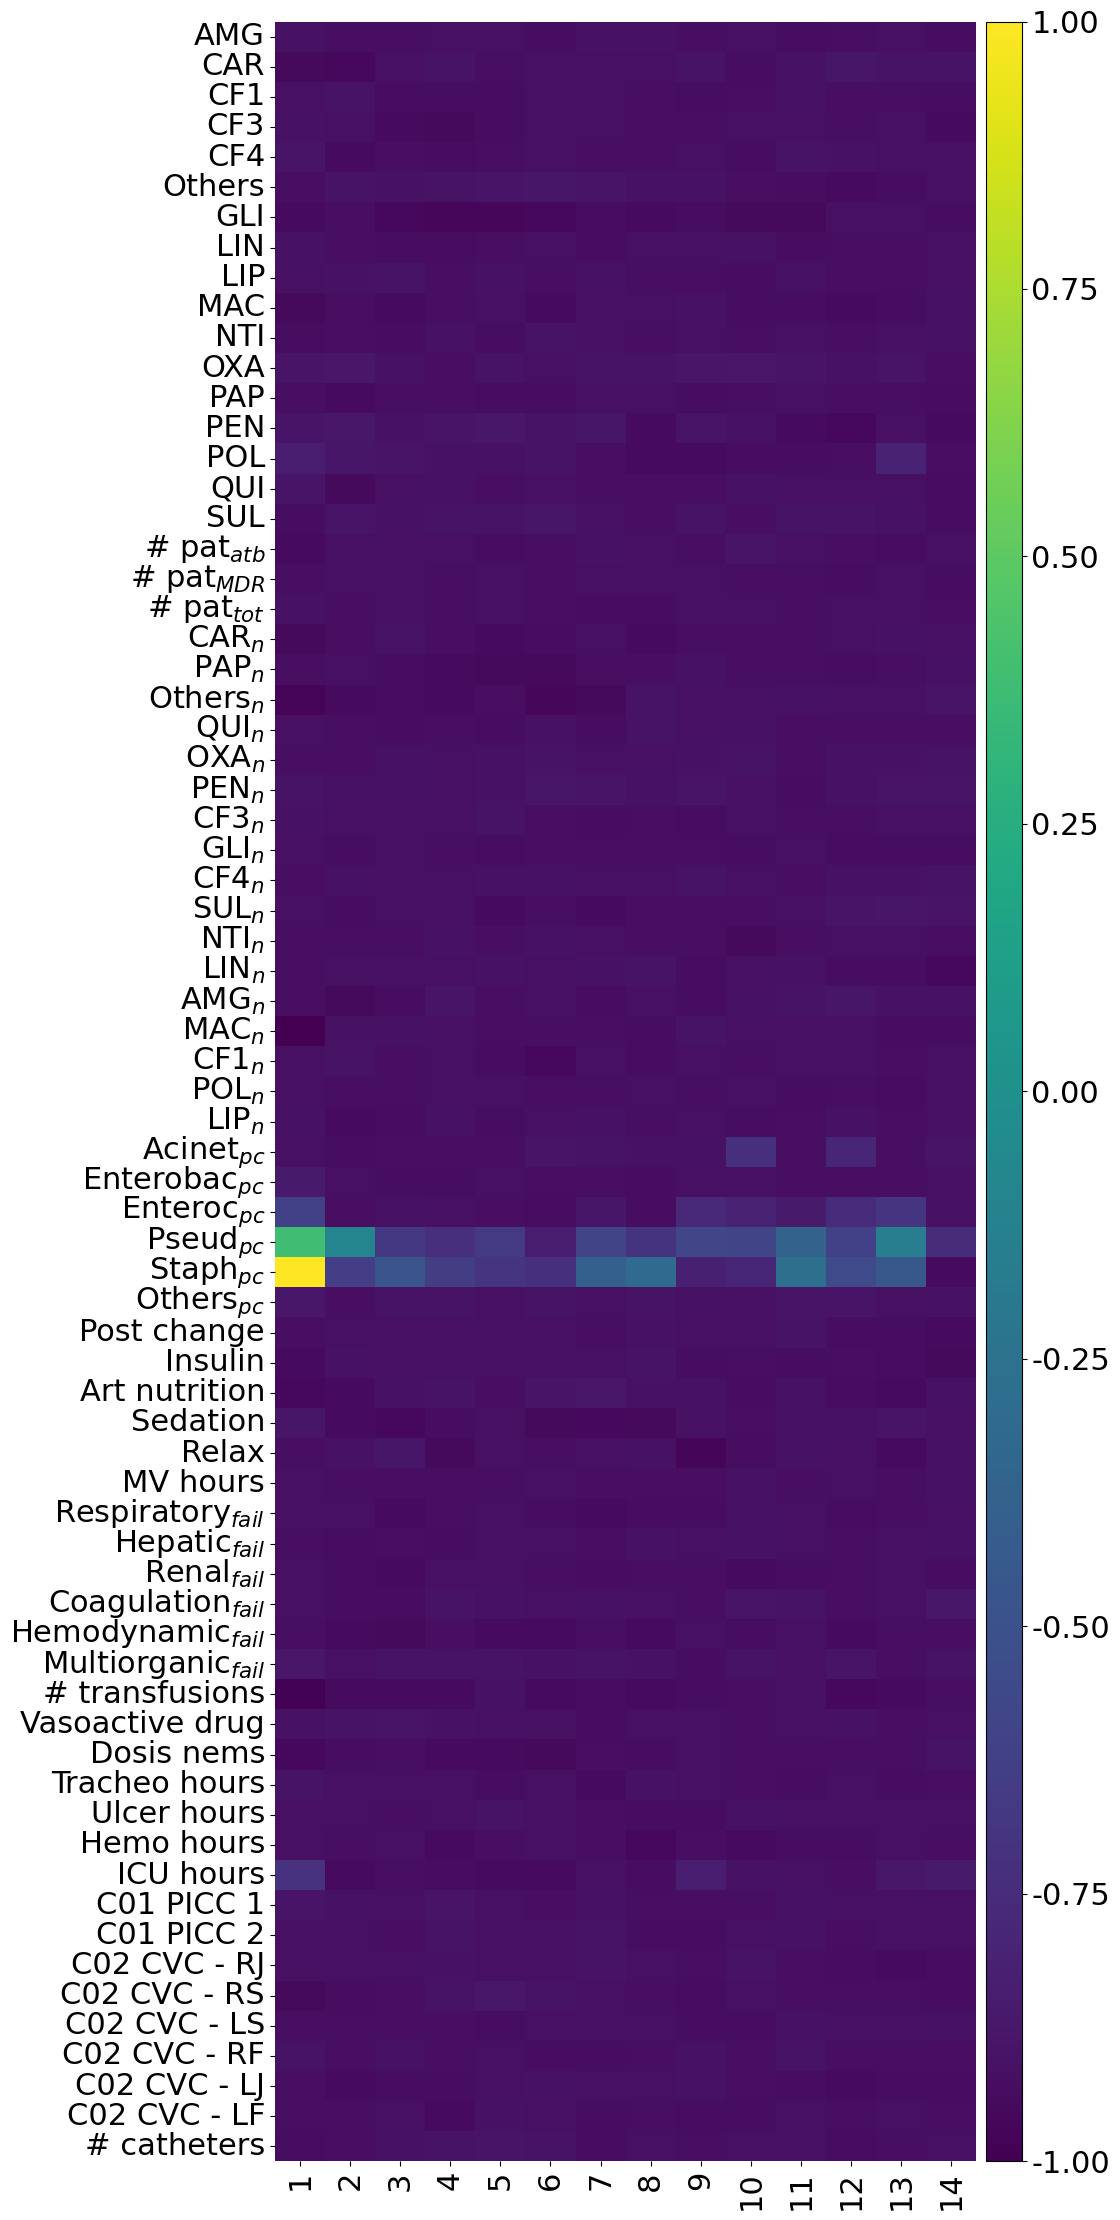

In [28]:
utils_visualizations_IT_SHAP.plot_shap_norm(matrix_pop, 
               matrix_amr, 
               reordered_indices, 
               final_order,
               f"../Figures/POST-HOC/SHAP_{split}_mdr_vanilla.pdf", 
               time,
               save_img=True
) 

## NON MDR PATIENTS

In [29]:
split_shap_noamr = []

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 1: #AMR patients are set to Nan
            patient_shap.loc[:, col] = np.nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #NonAMR patients keep the info

    split_shap_noamr.append(patient_shap)

**Visualize the Non MDR data without normalization**

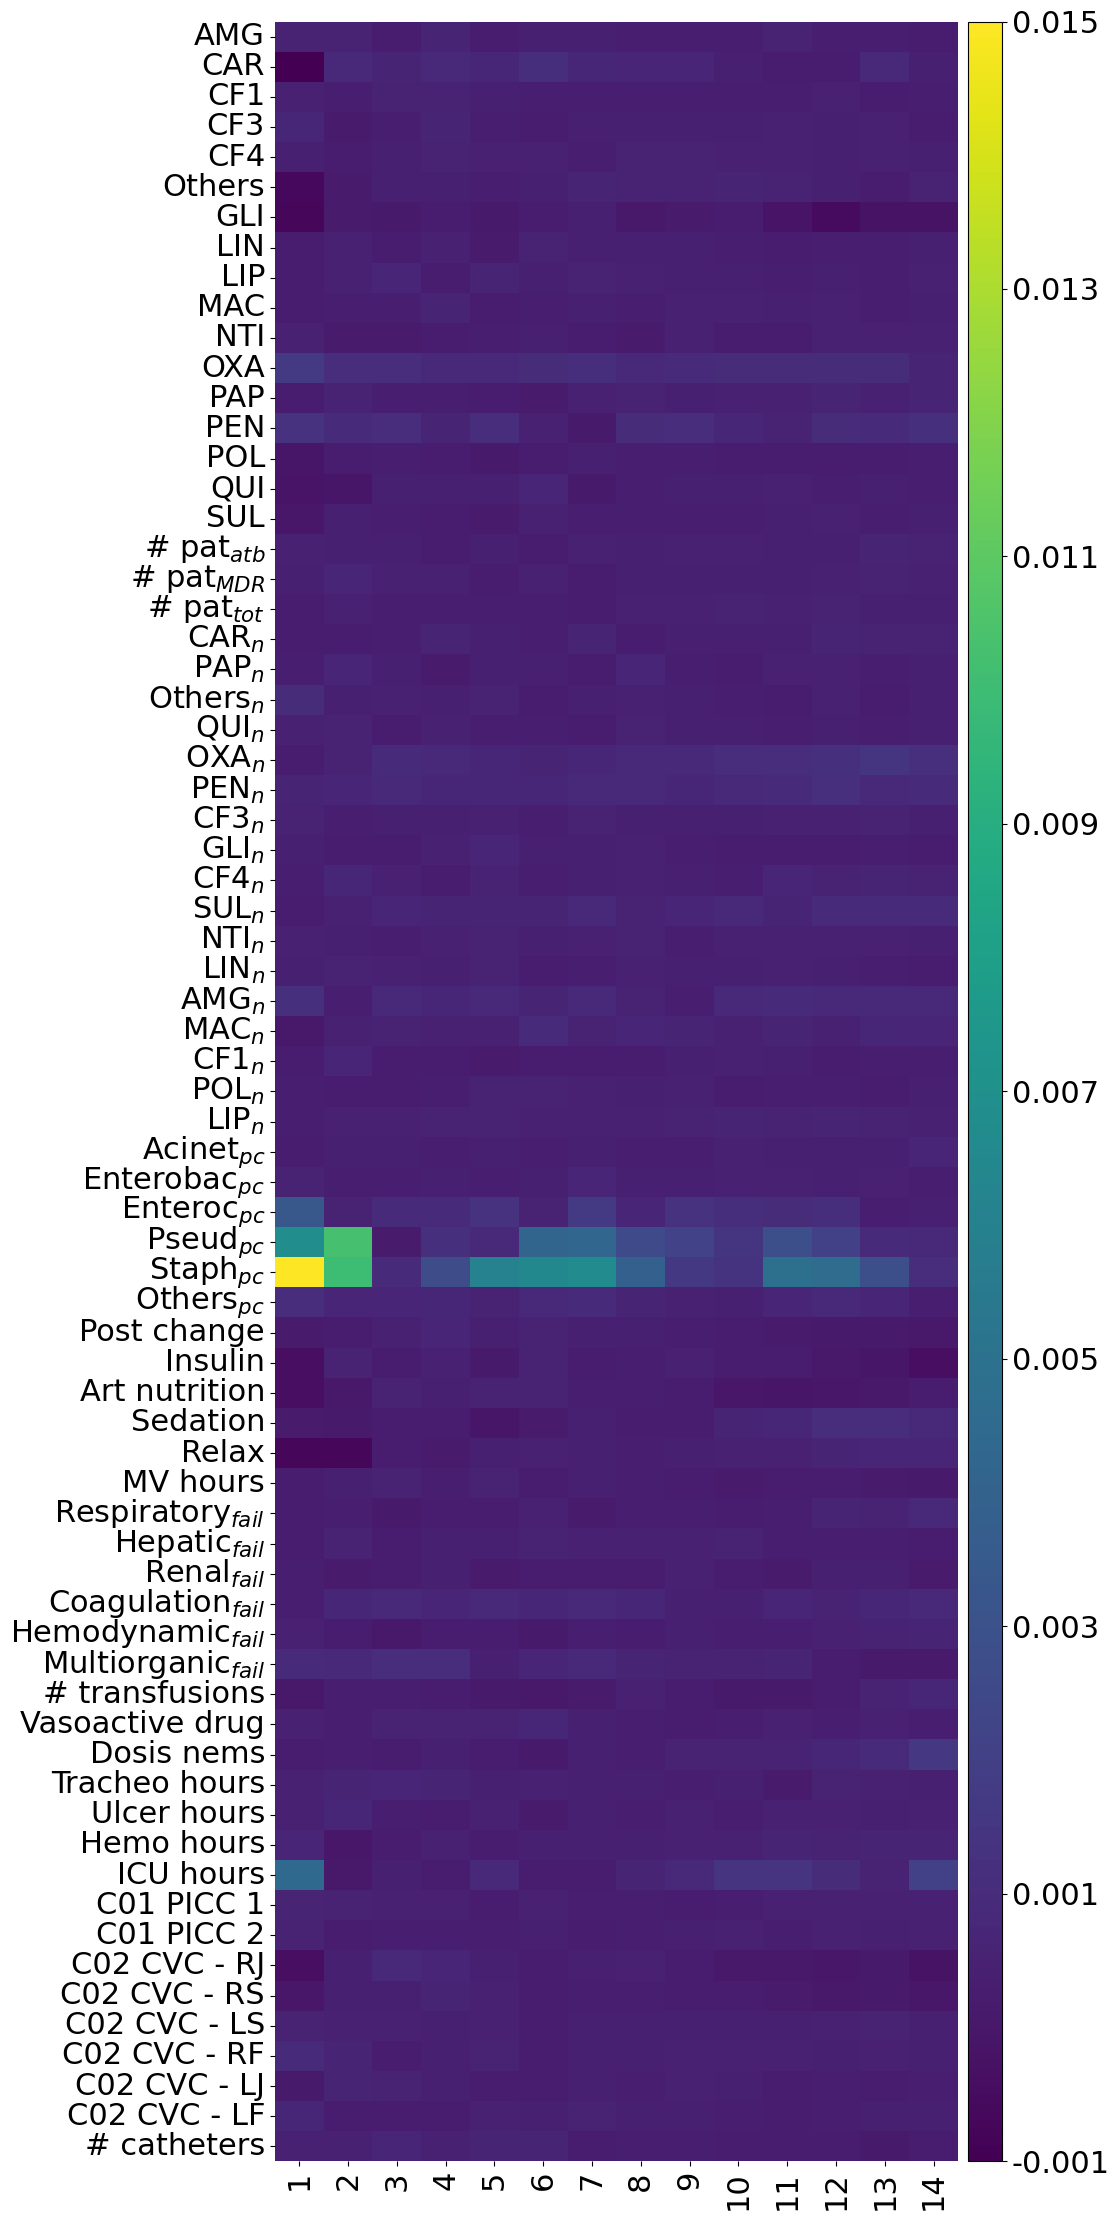

In [30]:
matrix_noamr = utils_visualizations_IT_SHAP.plot_shap(split_shap_noamr, features, reordered_indices, final_order,
                                                      f" ", time, save_img=False)

**Visualize the Non MDR data with normalization**

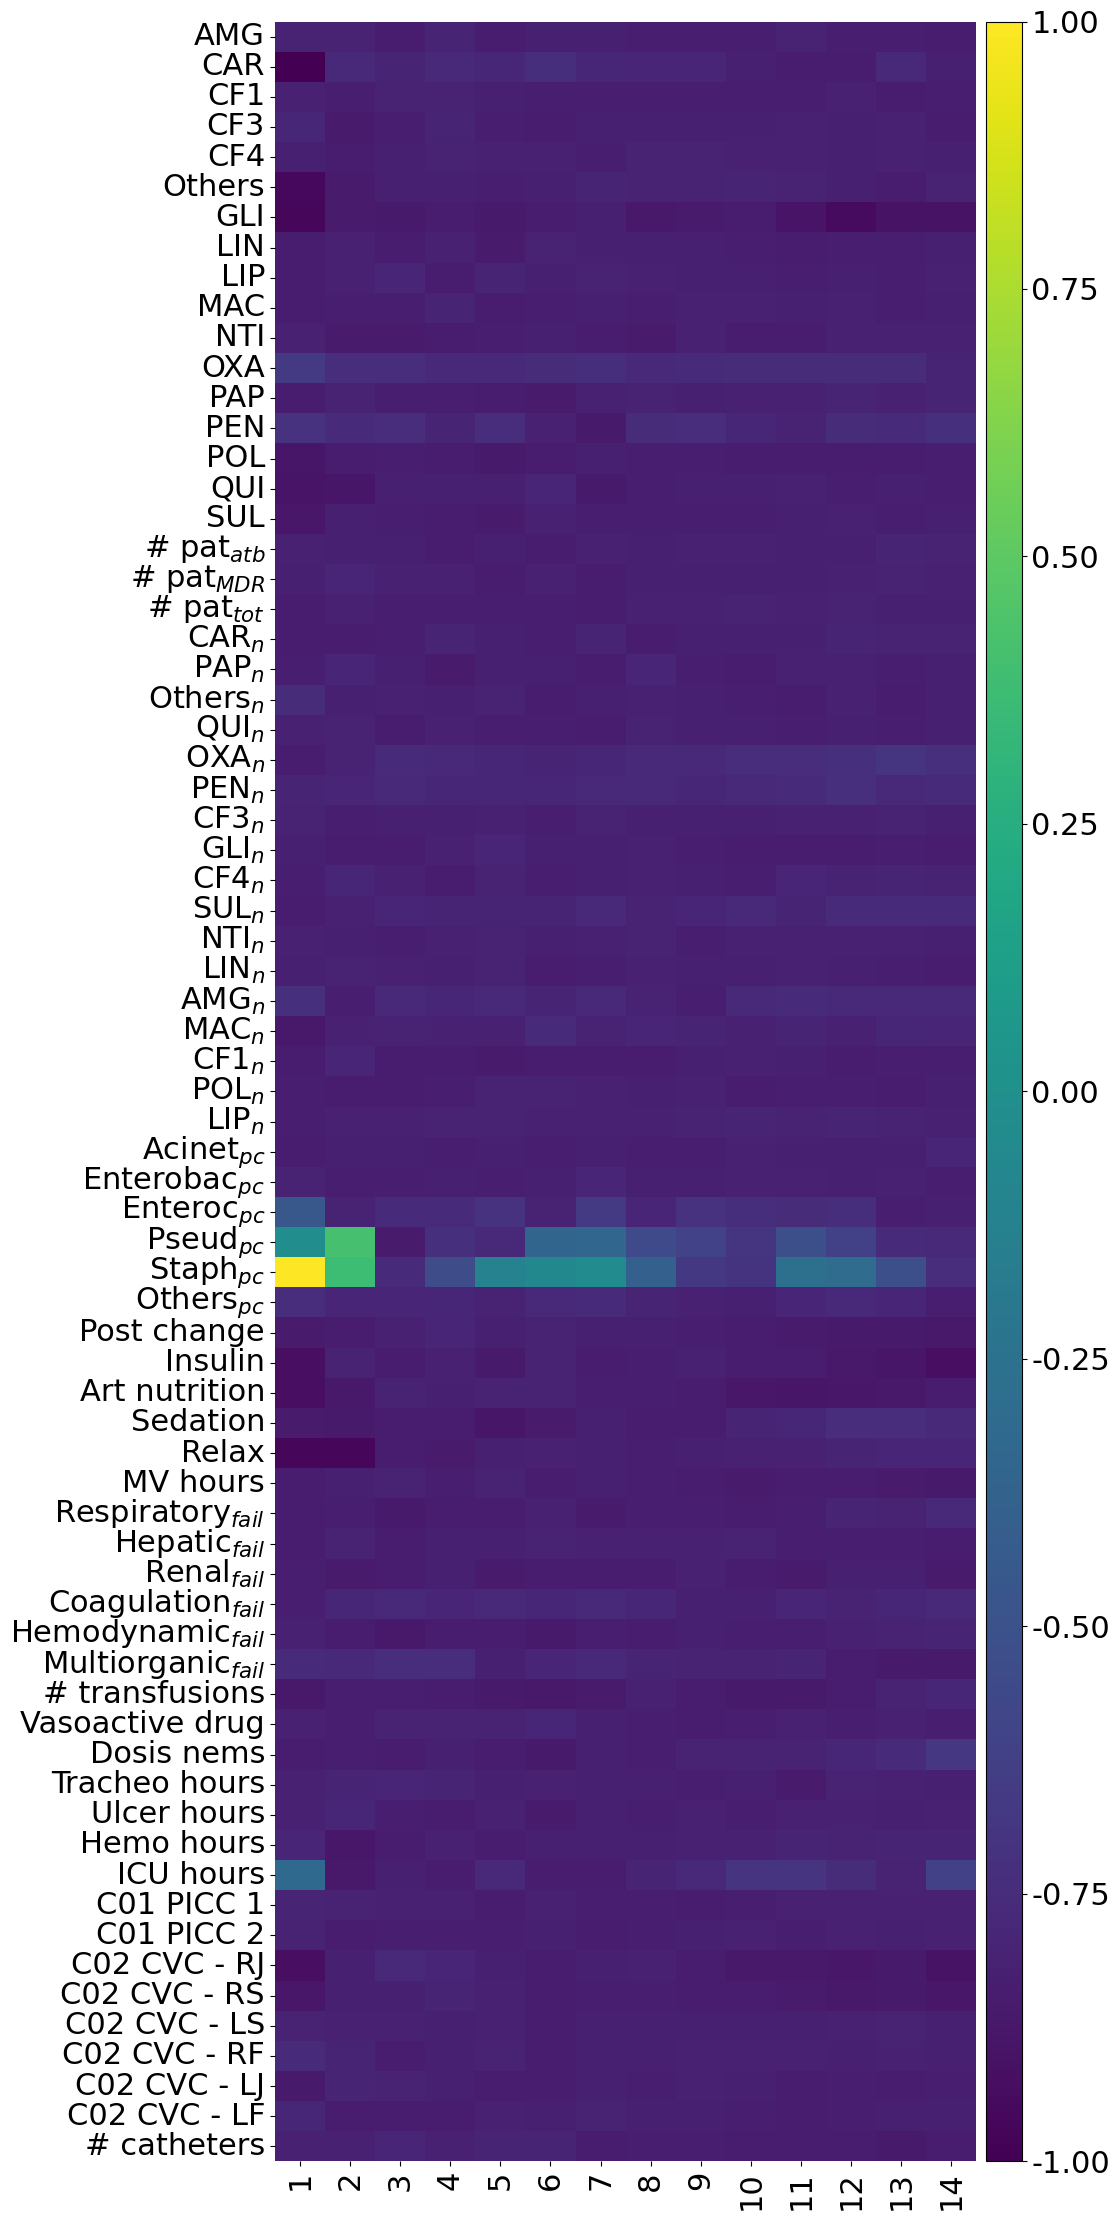

In [31]:
utils_visualizations_IT_SHAP.plot_shap_norm(matrix_pop, 
               matrix_noamr, 
               reordered_indices, 
               final_order,
               f"../Figures/POST-HOC/SHAP_{split}_nomdr_vanilla.pdf", 
               time,
               save_img=True
)